In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [2]:
mergedData = pd.read_excel('TabellaFinale.xlsx', sheet_name=None)

In [3]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0           7      2236     M   64 2021-02-26 00:00:00        27.30       422   
1           6      6426     M   47 2021-04-02 00:00:00         2.56       457   
2          18      8377     M   56 2020-08-31 00:00:00         7.80       243   
3          51     11463     M   71 2020-08-31 00:00:00        24.74       243   
4          53     11463     M   71 2021-03-31 10:54:33          NaN       456   

   num_visita  Charlson_Totale Charlson_Diabete  ...  DASS21 stress  \
0           0              NaN              NaN  ...            0.0   
1           0              2.0           0 = No  ...            3.0   
2           0              1.0           0 = No  ...            NaN   
3           0              3.0           0 = No  ...            NaN   
4           1              NaN              NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level  SF36 general health Resilience  
0               Subthreshold Insomnia                 75.0       64.0  
1  No Clinically Significant Insomnia                 10.0       54.0  
2                                 NaN                  NaN        NaN  
3                                 NaN                  NaN        NaN  
4  No Clinically Significant Insomnia                 90.0       88.0  

[5 rows x 80 columns]

In [4]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [5]:
df.head()

HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  num_visita  \
0      2236     M   64 2021-02-26 00:00:00        27.30       422           0   
1      6426     M   47 2021-04-02 00:00:00         2.56       457           0   
2      8377     M   56 2020-08-31 00:00:00         7.80       243           0   
3     11463     M   71 2020-08-31 00:00:00        24.74       243           0   
4     11463     M   71 2021-03-31 10:54:33          NaN       456           1   

   Charlson_Totale Charlson_Diabete  Stifness  ...  DASS21 stress  \
0              NaN              NaN       6.7  ...            0.0   
1              2.0           0 = No       NaN  ...            3.0   
2              1.0           0 = No       NaN  ...            NaN   
3              3.0           0 = No       NaN  ...            NaN   
4              NaN              NaN       NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level SF36 general health Resilience  
0               Subthreshold Insomnia                75.0       64.0  
1  No Clinically Significant Insomnia                10.0       54.0  
2                                 NaN                 NaN        NaN  
3                                 NaN                 NaN        NaN  
4  No Clinically Significant Insomnia                90.0       88.0  

[5 rows x 79 columns]

In [6]:
dfSenzaData = df.drop(columns=['DATA', 'num_visita', 'DATA_INT'])

In [7]:
dfSenzaData.to_csv('TabellaFinaleSenzaData_2.csv')
#dfSenzaData.to_excel('TabellaFinaleSenzaData.xlsx')

In [8]:
dfSenzaData = dfSenzaData[(dfSenzaData['FrailtyPhenotypeBool'].notna()) & (dfSenzaData['Resilience'].notna())]

In [9]:
#soloETA = dfSenzaData[['HDN_CODE','ETA']]

In [10]:
#soloETA.to_csv('SoloETA.csv')

## Parametri utente

In [9]:
input_data = 'TabellaFinaleSenzaData_2.csv' 
mode = 'correlated_attribute_mode'
description_file = 'description_completa_correlated_2.json'
synthetic_data = 'synthetic_data_correlated.csv'

In [11]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 15

# specify categorical attributes
categorical_attributes = {'Sesso':True,
                            #'num_visita':True,
                            'Charlson_Diabete':True,
                            'Charlson_Totale':True,
                            'FrailtyPhenotypeBool':True,
                            'Pneumo_ScalaBorg':True,
                            'TestCammino6Min_BorgBase':True,
                            'TestCammino6Min_BorgEnd':True,
                            'Alcool':True,
                            'Fumatore':True,
                            'Sintomi_Cadute':True,
                            'Sintomi_DifficoltaDeglutizione':True,
                            'Sintomi_DistUdito':True,
                            'Sintomi_DistVista':True,
                            'SintomiNeuropsico_Ageusia':True,
                            'SintomiNeuropsico_Anosmia':True,
                            'SintomiNeuropsico_Astenia':True,
                            'SintomiNeuropsico_CognitivoAttenzione':True,
                            'SintomiNeuropsico_CognitivoConcentrazione':True,
                            'SintomiNeuropsico_CognitivoMemoria':True,
                            'SintomiNeuropsico_DistEquilibrio':True,
                            'SintomiNeuropsico_DistSonno':True,
                            'SintomiNeuropsico_DoloriMuscolari':True,
                            'SintomiNeuropsico_Effluvium':True,
                            'Descrizione':True,
                            'AssumePiuFarmaciGiorno':True,
                            'PersoPeso':True,
                            'CamminareMenoUltimoAnno':True,
                            'CaduteUltimoAnno':True,
                            'SentirsiSolo':True,
                            'PuoContareSuQualcuno':True,
                            'DifficoltaEconomicheSpeseSanitarie':True,
                            'EQ5D5L health score':True,
                            'DASS21 stress':True,
                            'Anxiety level':True,
                            'DASS21 depression':True,
                            'Depression level':True,
                            'Insomnia severity index':True,
                            'ISI level':True
                         }

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 1000

In [13]:
# istanzio il data describer
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                         k = degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.describe_dataset_in_random_mode(input_data)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT Glicemia
Adding attribute EGA_PaO2
Adding attribute CALORIE
Adding attribute Pneumo_ProveFunzResp_FEV_FVCPre
Adding attribute Sintomi_Cadute
Adding attribute D_dimero
Adding attribute AssumePiuFarmaciGiorno
Adding attribute ETA
Adding attribute SintomiNeuropsico_CognitivoConcentrazione
Adding attribute PCR
Adding attribute DASS21 stress
Adding attribute SintomiNeuropsico_DistSonno
Adding attribute SF36 general health
Adding attribute BMI
Adding attribute Sesso
Adding attribute SintomiNeuropsico_Effluvium
Adding attribute BMI_Ricovero
Adding attribute EQ5D5L
Adding attribute TestCammino6Min_Distanza
Adding attribute Sintomi_DifficoltaDeglutizione
Adding attribute PuoContareSuQualcuno
Adding attribute Descrizione
Adding attribute GlobuliBianchi
Adding attribute TempoDallaVisita
Adding attribute SintomiNeuropsico_Astenia
Adding attribute ASCVD_Score
Adding attribute Charlson_Totale
Adding attribute PROTEINE_P

In [14]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    EGA_PaO2                                  has parents ['Glicemia'].
    CALORIE                                   has parents ['EGA_PaO2', 'Glicemia'].
    Pneumo_ProveFunzResp_FEV_FVCPre           has parents ['EGA_PaO2', 'Glicemia'].
    Sintomi_Cadute                            has parents ['EGA_PaO2', 'Glicemia'].
    D_dimero                                  has parents ['Sintomi_Cadute', 'EGA_PaO2'].
    AssumePiuFarmaciGiorno                    has parents ['D_dimero', 'Sintomi_Cadute'].
    ETA                                       has parents ['AssumePiuFarmaciGiorno', 'CALORIE'].
    SintomiNeuropsico_CognitivoConcentrazione has parents ['AssumePiuFarmaciGiorno', 'Sintomi_Cadute'].
    PCR                                       has parents ['Pneumo_ProveFunzResp_FEV_FVCPre', 'Glicemia'].
    DASS21 stress                             has parents ['PCR', 'CALORIE'].
    SintomiNeuropsico_DistSonno               has parents ['AssumePiuFarmaciGior

In [12]:

generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [13]:
dfs = pd.read_csv(synthetic_data)

(array([  4.,  10.,  11.,  42.,  81., 108., 119.,  71.,  83.,  22.]),
 array([14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. , 81.5, 89. ]),
 <BarContainer object of 10 artists>)

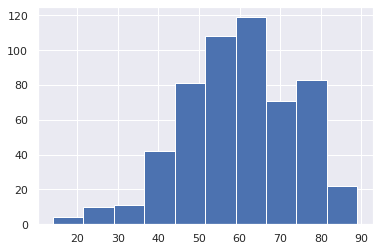

In [14]:
plt.hist(df['ETA'])

(array([  2.,   4.,   2.,   5.,   5.,   4.,   6.,   4.,   8., 914.]),
 array([14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. , 81.5, 89. ]),
 <BarContainer object of 10 artists>)

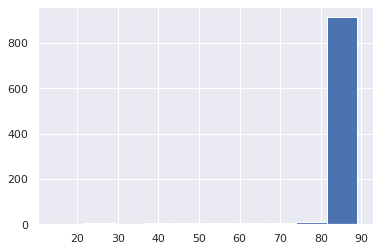

In [15]:
plt.hist(dfs['ETA'])

## Ispector

In [16]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)


HDN_CODE
Sesso
ETA
ASCVD_Score
Charlson_Totale
Charlson_Diabete
Stifness
CAP
FrailtyPhenotypeBool
EGA_HB
EGA_PaO2
EGA_SatO2
Pneumo_ProveFunzResp_FEV_FVCPre
Pneumo_ProveFunzResp_MEP
Pneumo_ProveFunzResp_MIP
Pneumo_ScalaBorg
TestCammino6Min_BorgBase
TestCammino6Min_BorgEnd
TestCammino6Min_Distanza
Alcool
BMI
BMI_Ricovero
BMIPostRicovero


/home/gibbo/.local/lib/python3.7/site-packages/DataSynthesizer/ModelInspector.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 5), dpi=120)


Fumatore
Pack_years
Sintomi_Cadute
Sintomi_DifficoltaDeglutizione
Sintomi_DistUdito
Sintomi_DistVista
SintomiNeuropsico_Ageusia
SintomiNeuropsico_Anosmia
SintomiNeuropsico_Astenia
SintomiNeuropsico_CognitivoAttenzione
SintomiNeuropsico_CognitivoConcentrazione
SintomiNeuropsico_CognitivoMemoria
SintomiNeuropsico_DistEquilibrio
SintomiNeuropsico_DistSonno
SintomiNeuropsico_DoloriMuscolari
SintomiNeuropsico_Effluvium
VitaCm
CALORIE
PROTEINE_Perc
CogStateScore_Esito
GlobuliBianchi
Linfociti_Assoluti
Neutrofili
Piastrine
GPT_ALT
D_dimero
Fibrinogeno
Glicemia
INSULINA
PCR
DurataRicovero
TempoDallaVisita
Descrizione
AssumePiuFarmaciGiorno
PersoPeso
CamminareMenoUltimoAnno
CaduteUltimoAnno
SentirsiSolo
PuoContareSuQualcuno
DifficoltaEconomicheSpeseSanitarie
EQ5D5L
EQ5D5L health score
Intrinsic Capacity (%)
DASS21 stress
Stress level
DASS21 anxiety
Anxiety level
DASS21 depression
Depression level
Insomnia severity index
ISI level
SF36 general health
Resilience


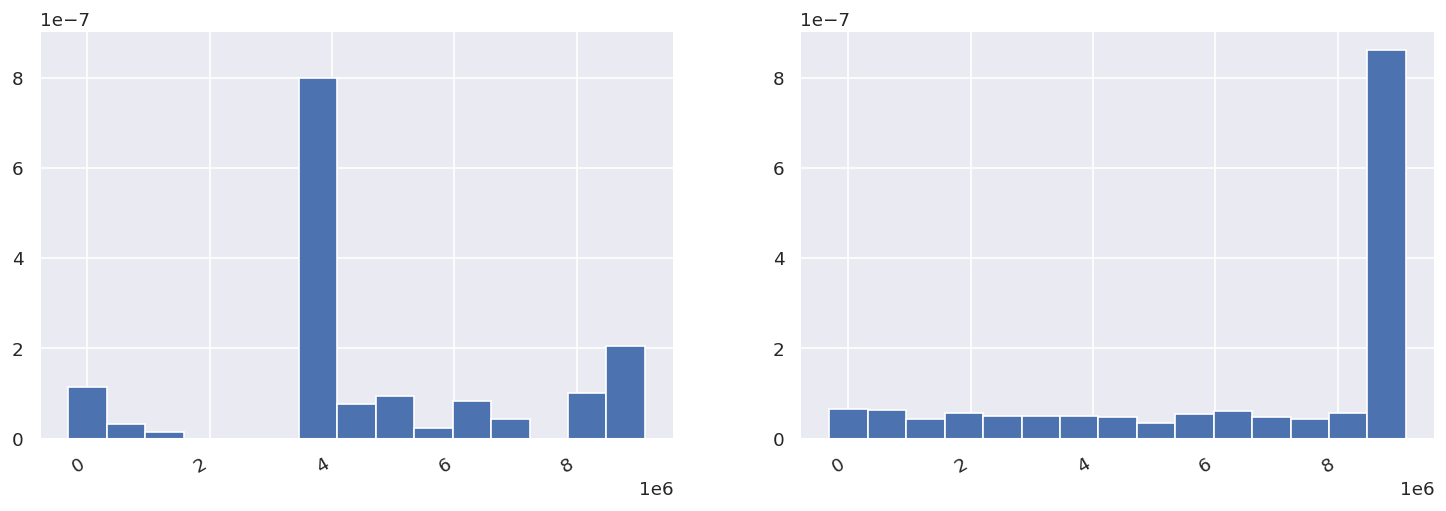

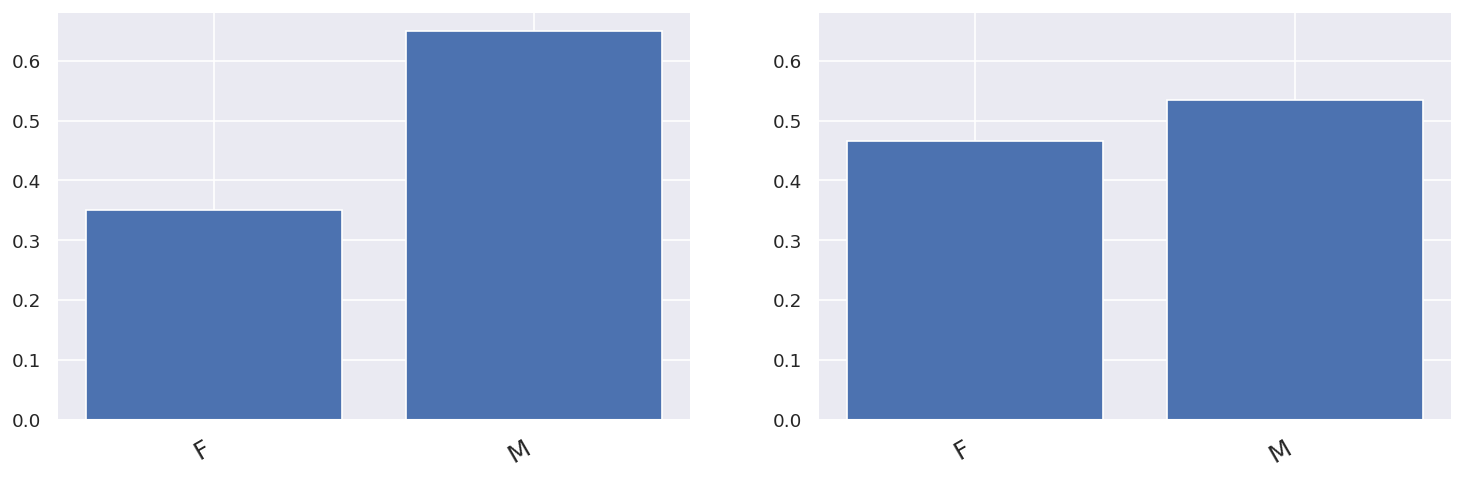

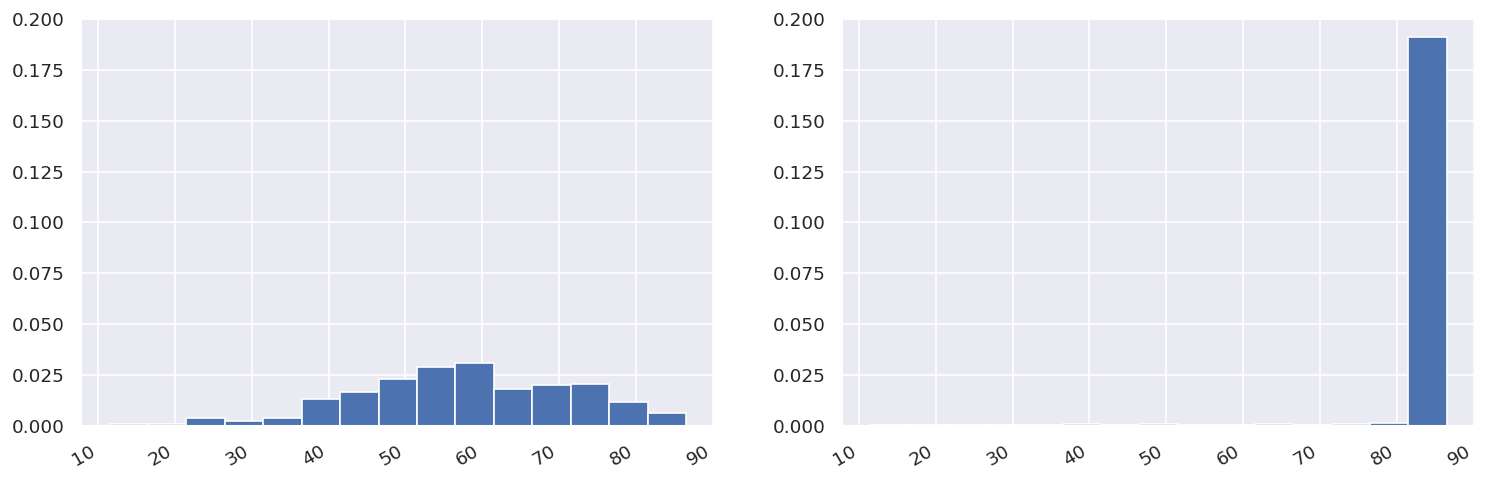

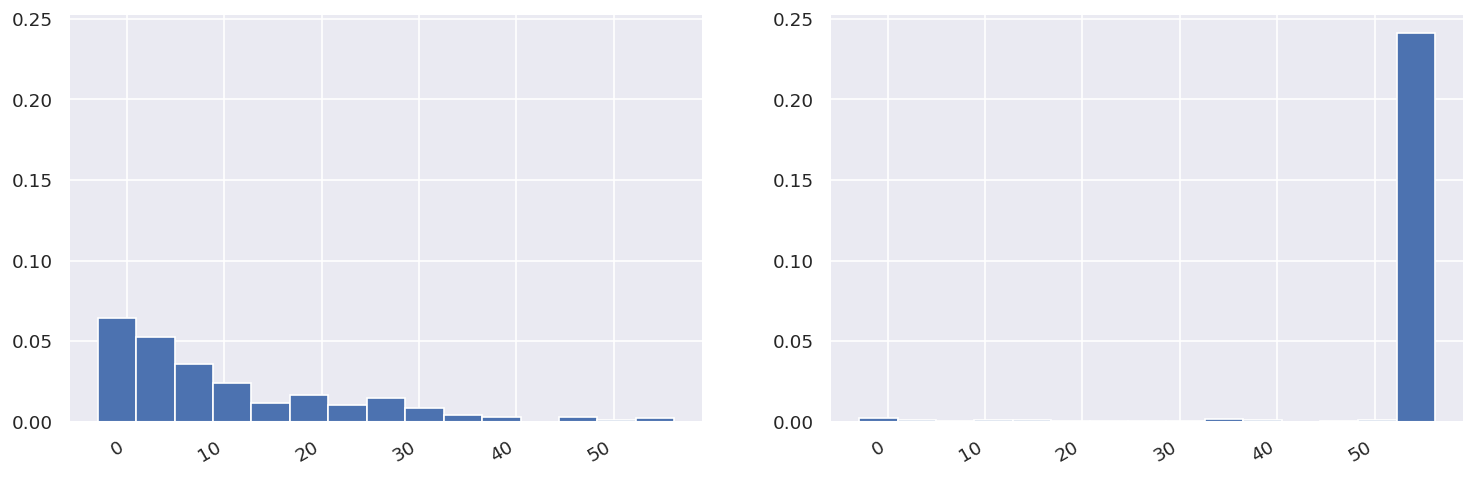

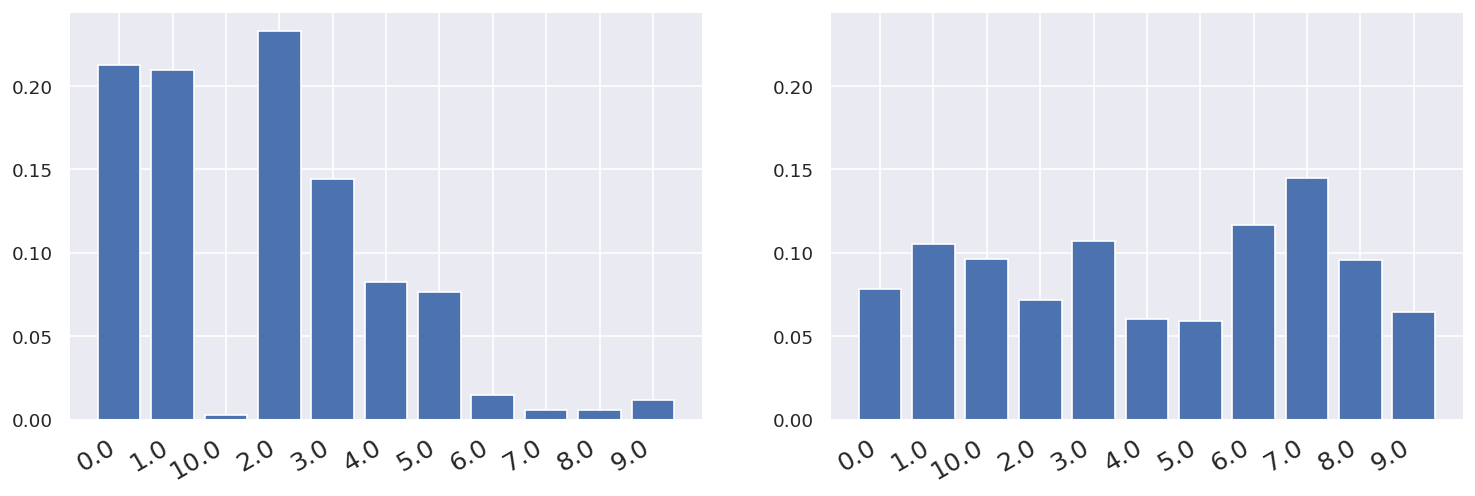

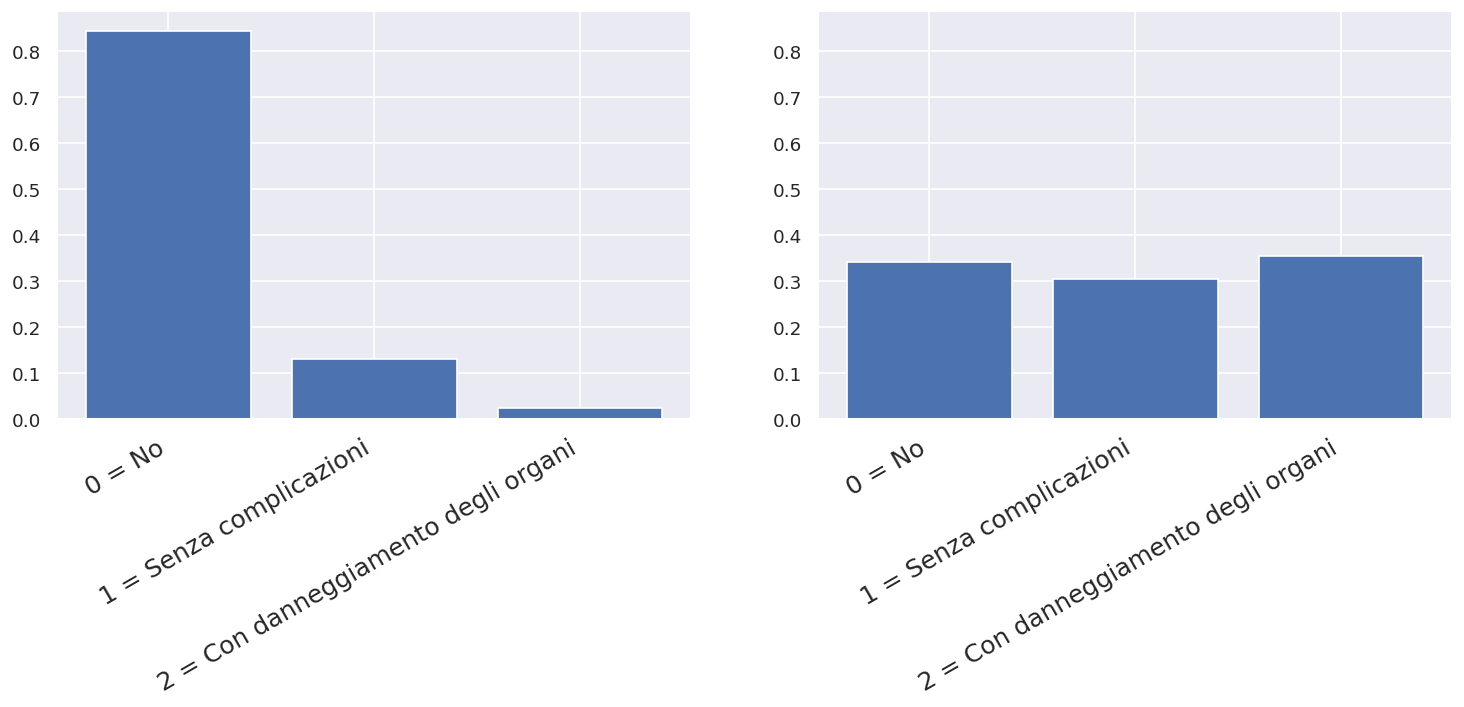

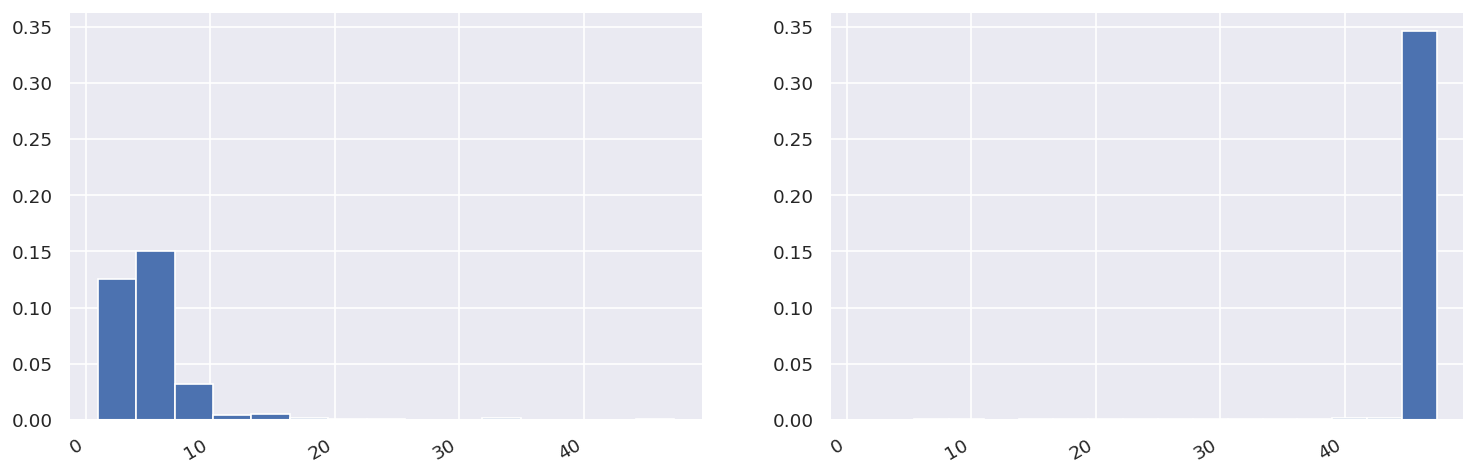

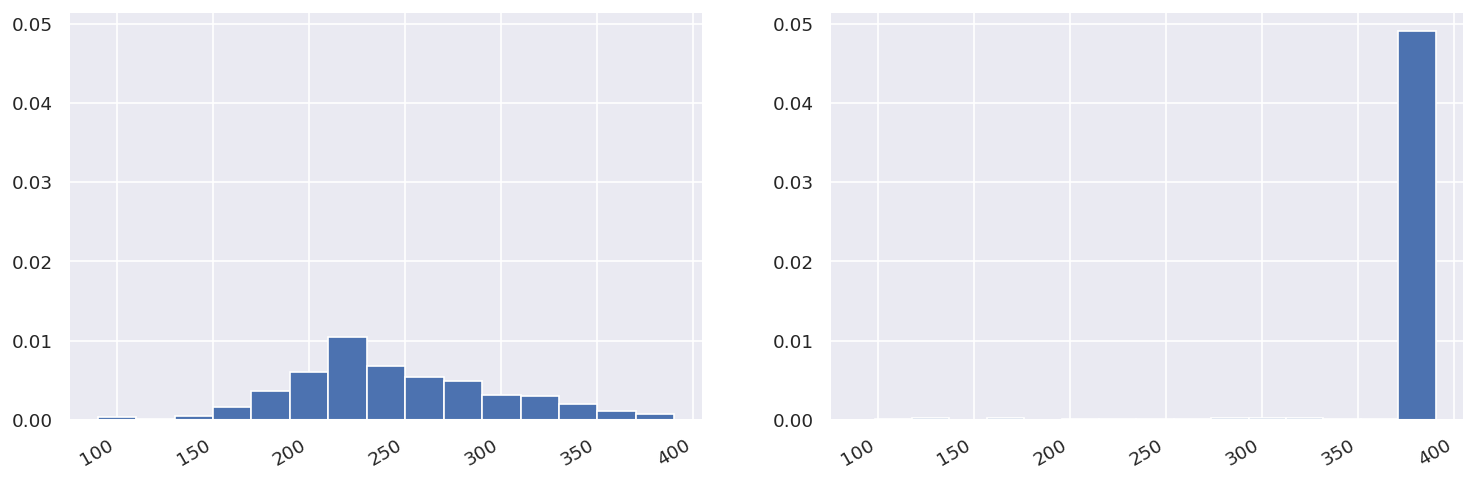

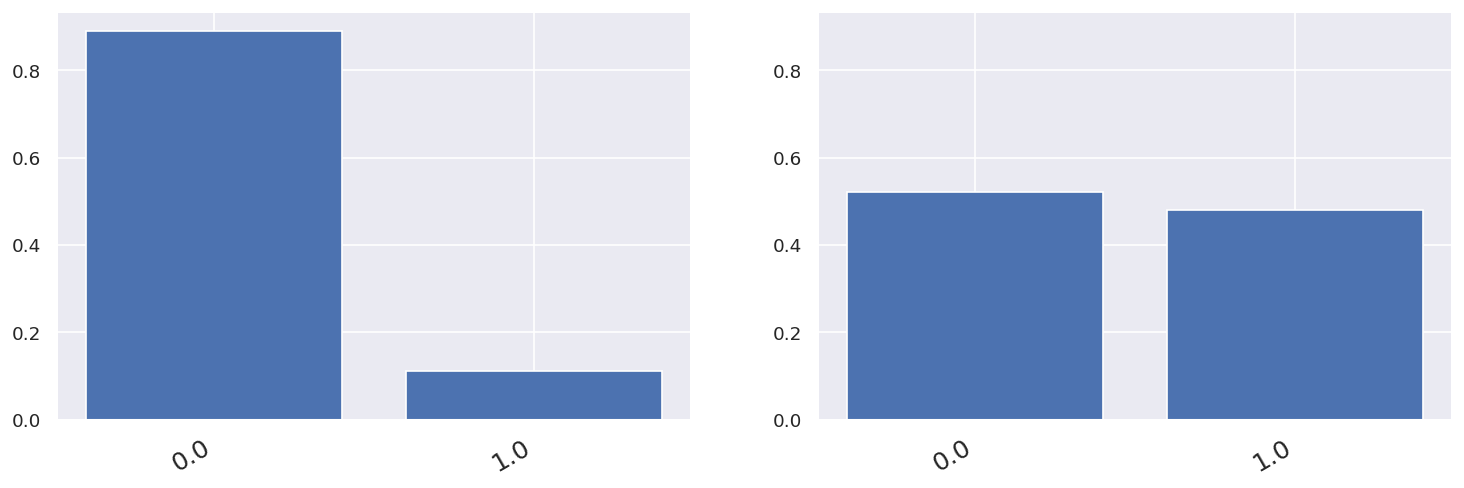

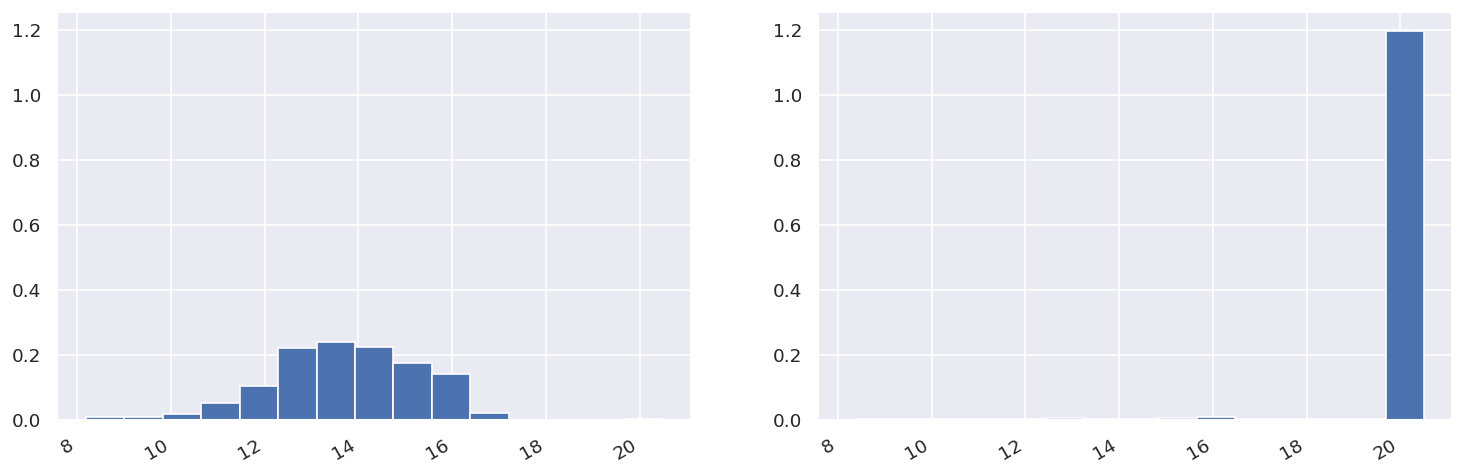

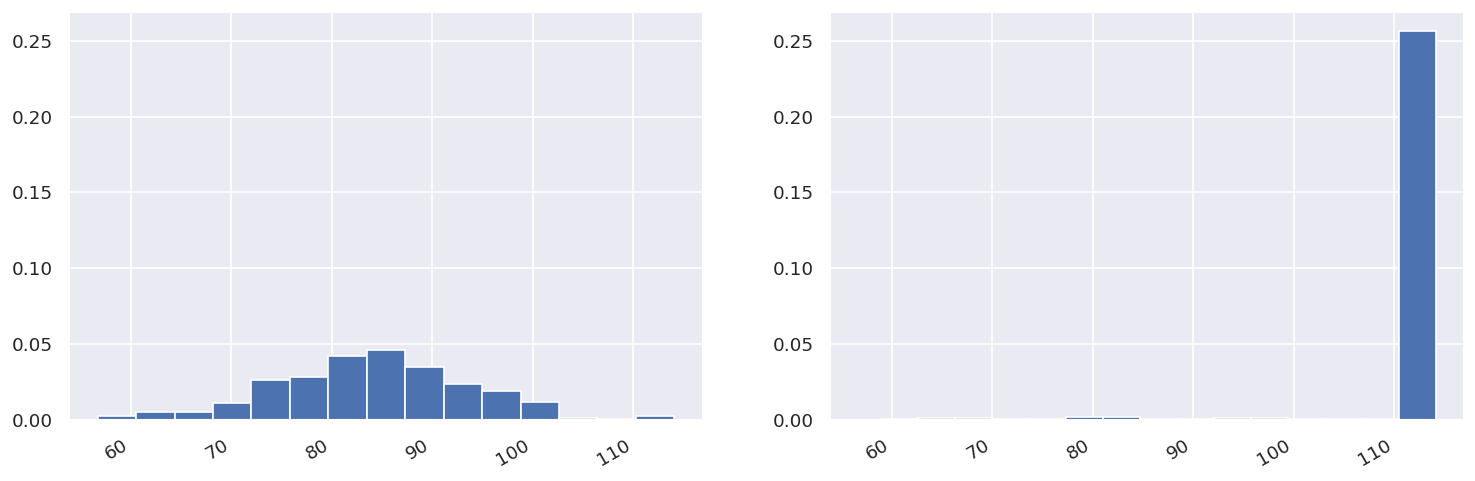

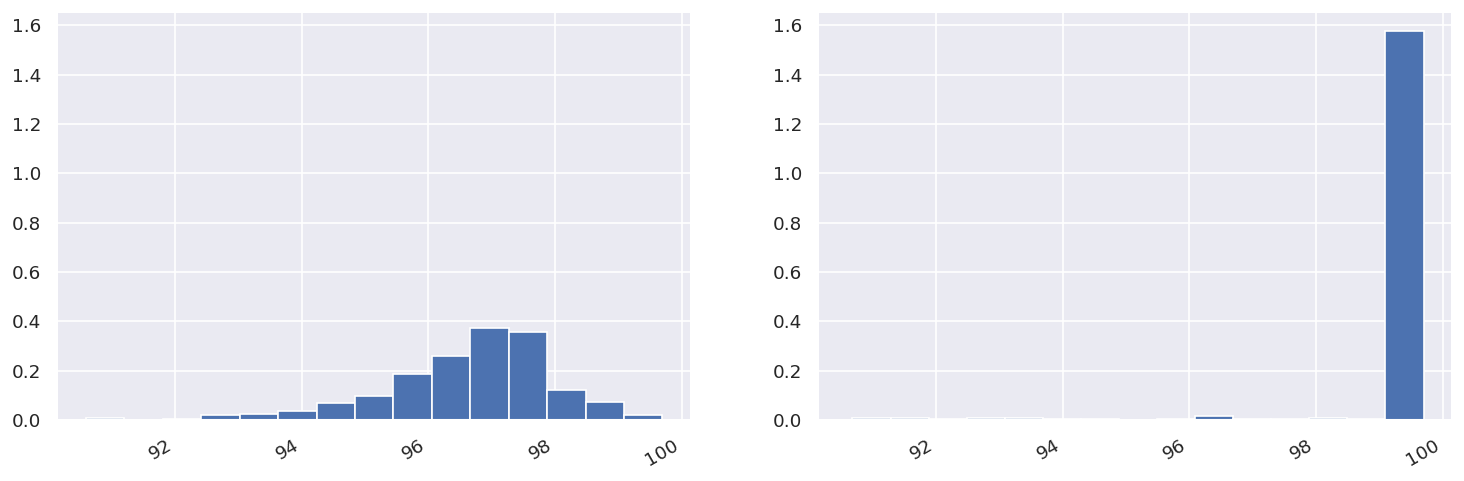

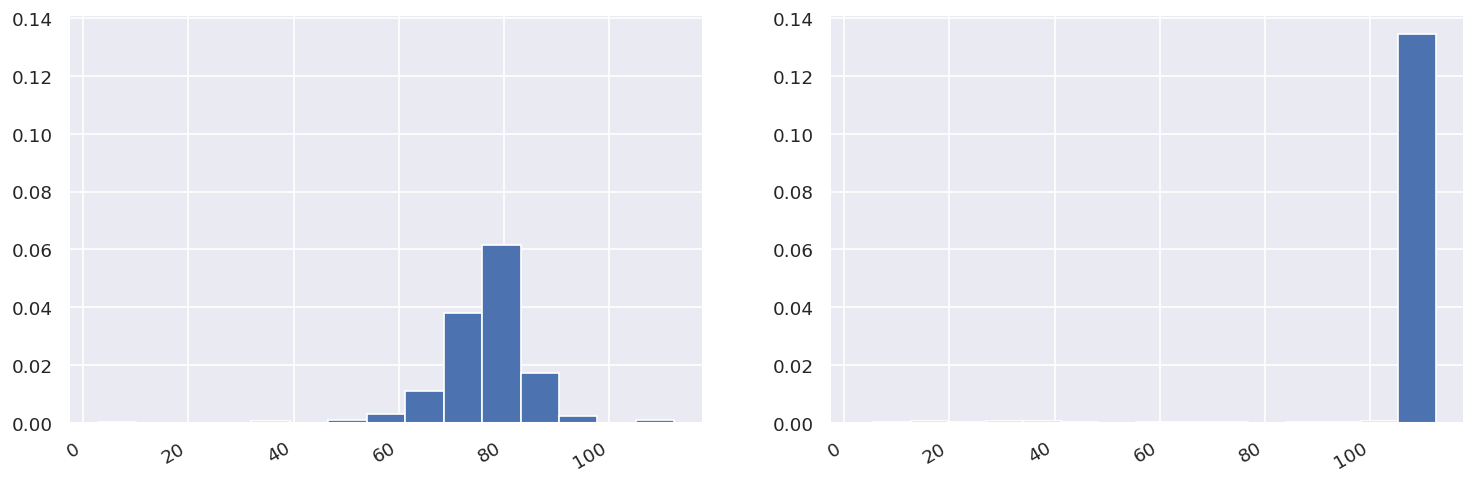

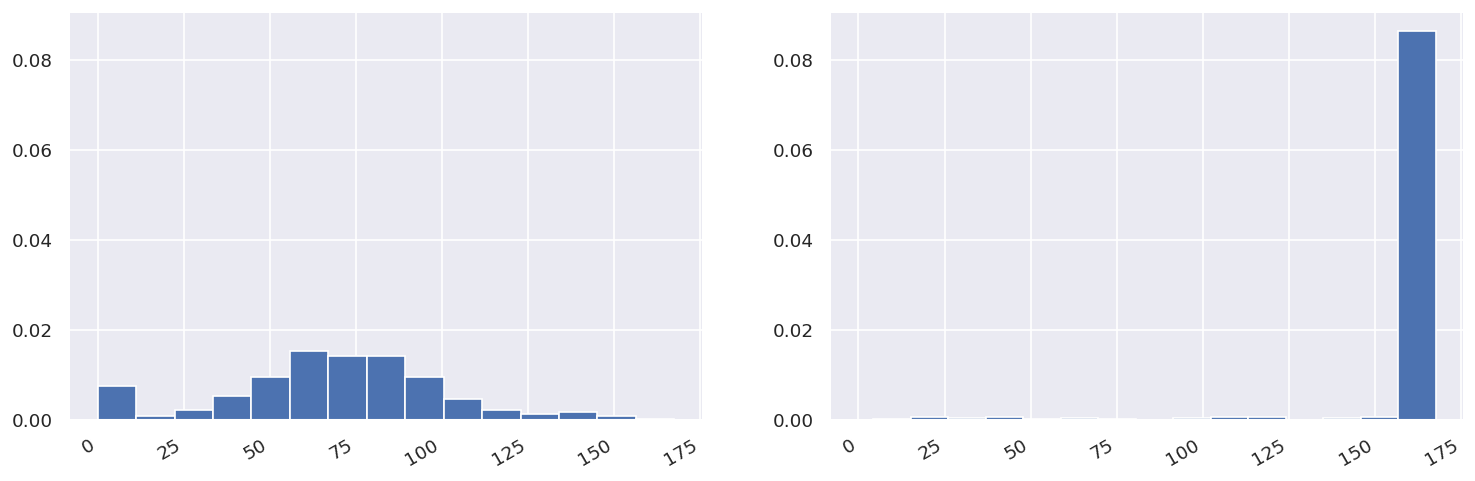

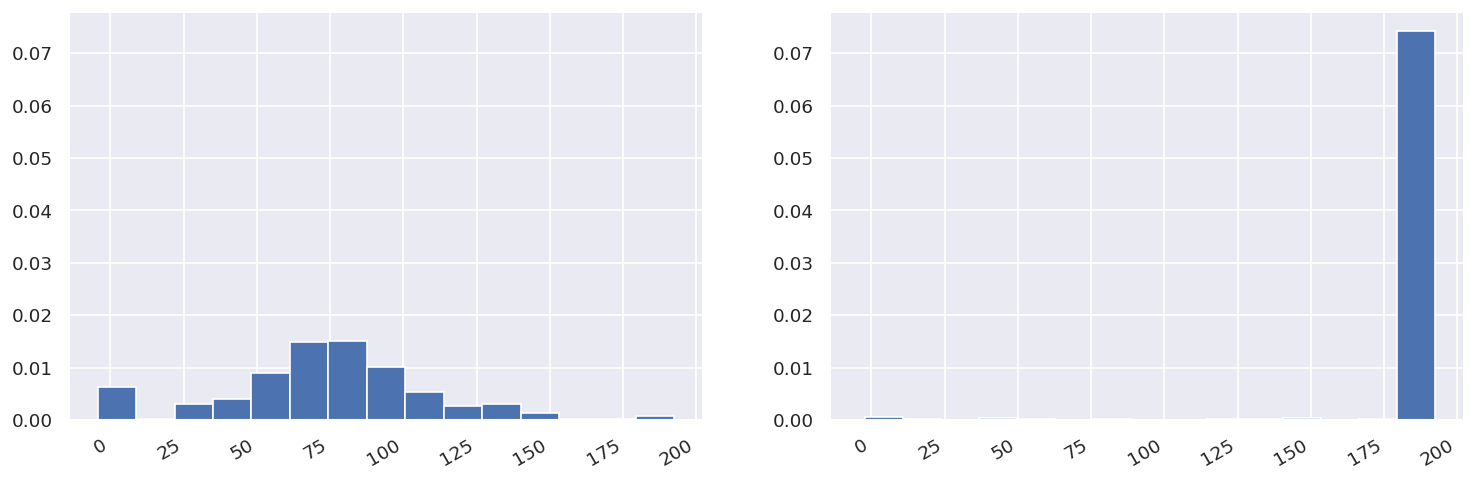

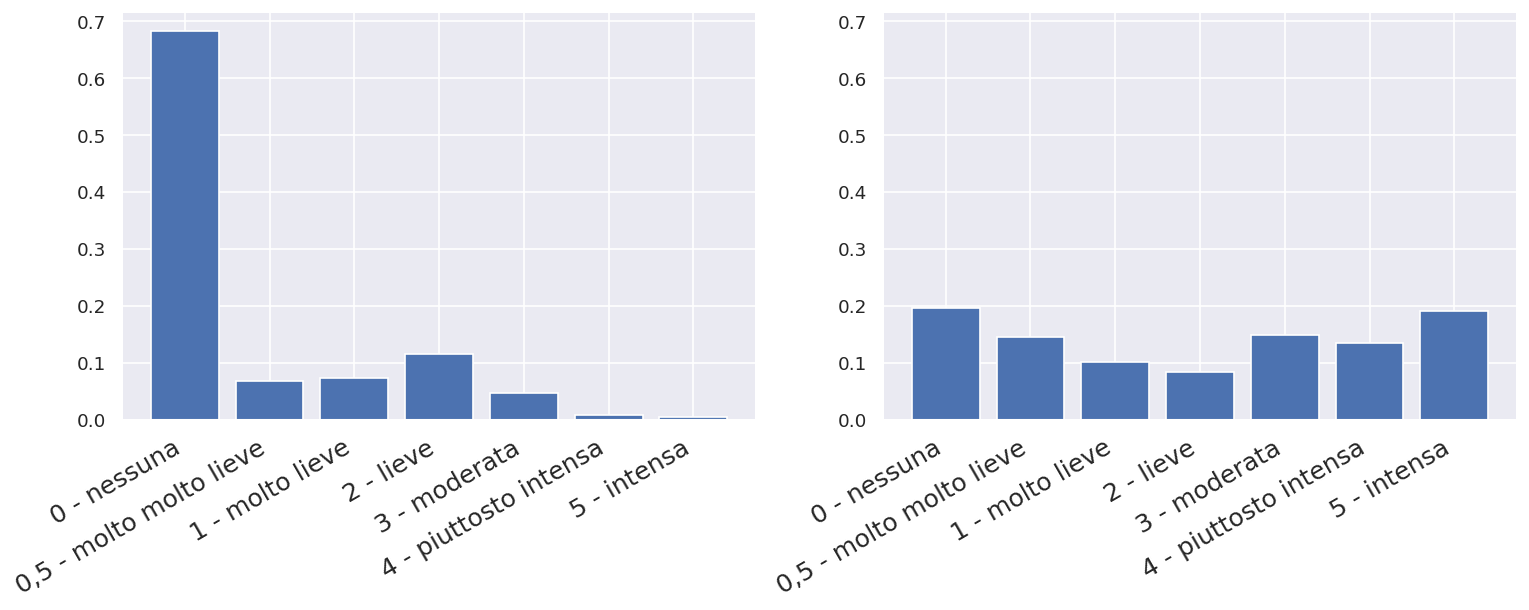

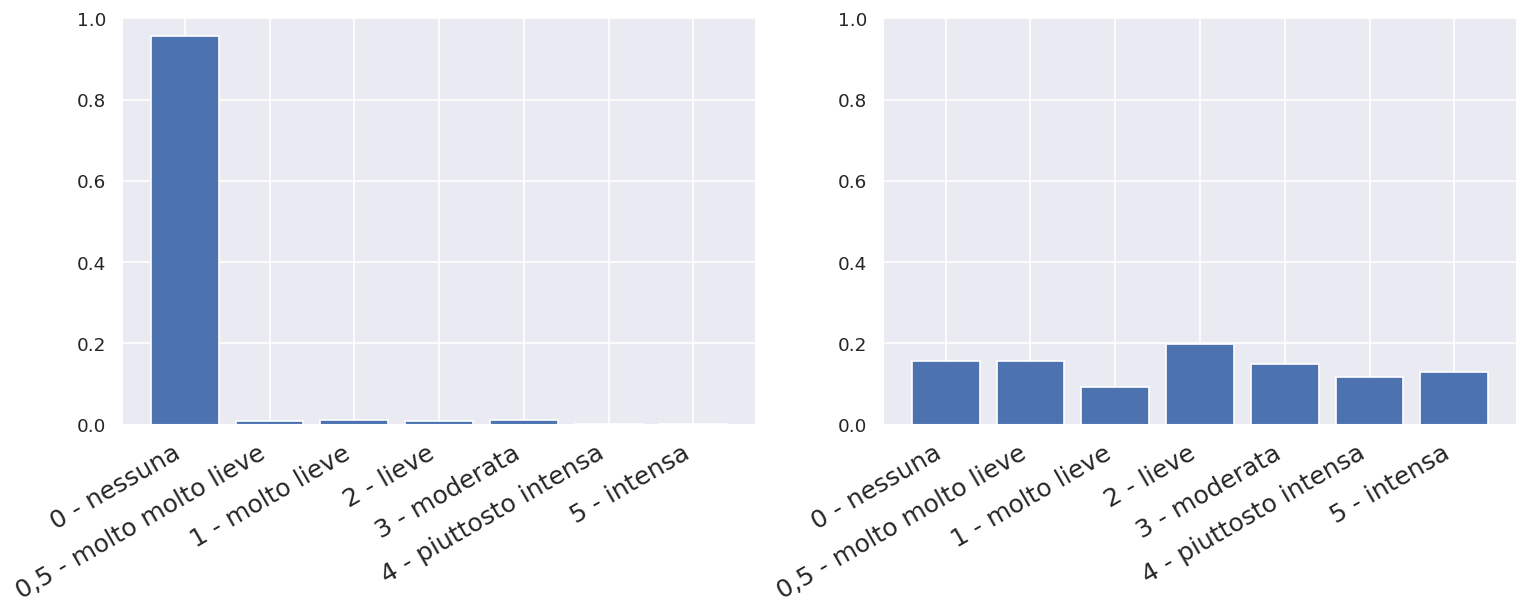

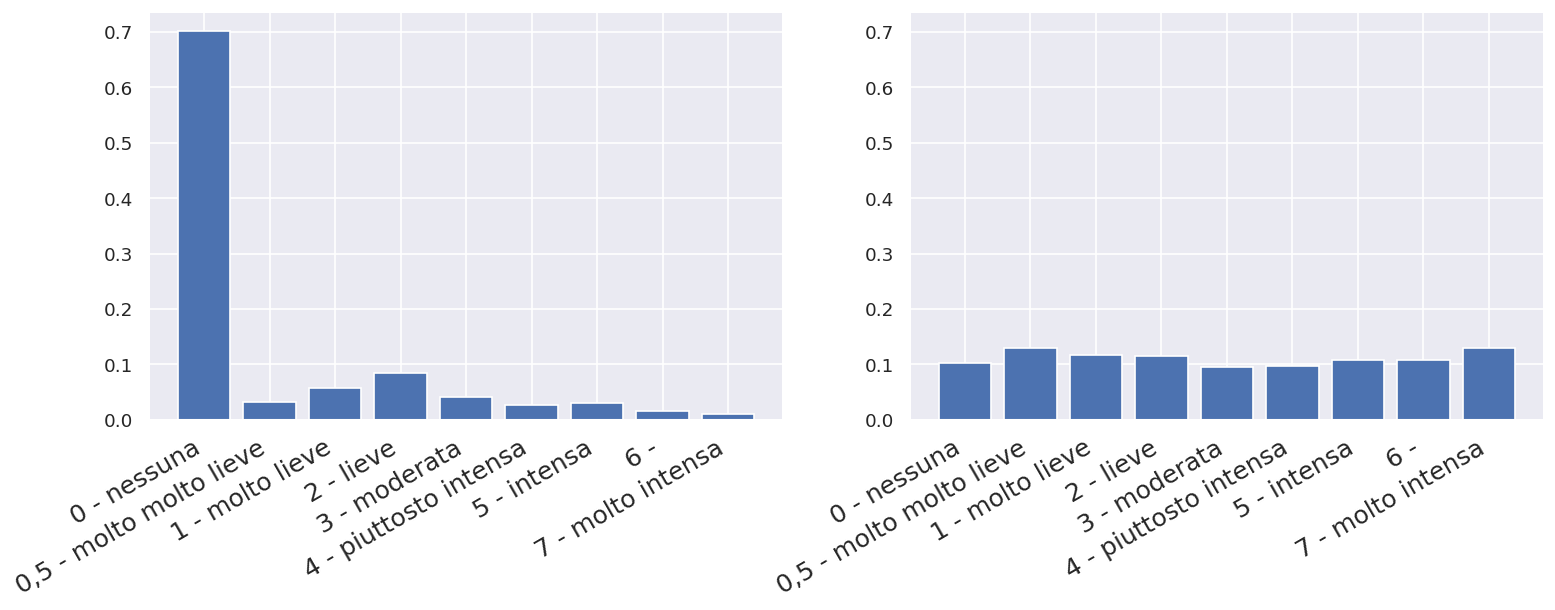

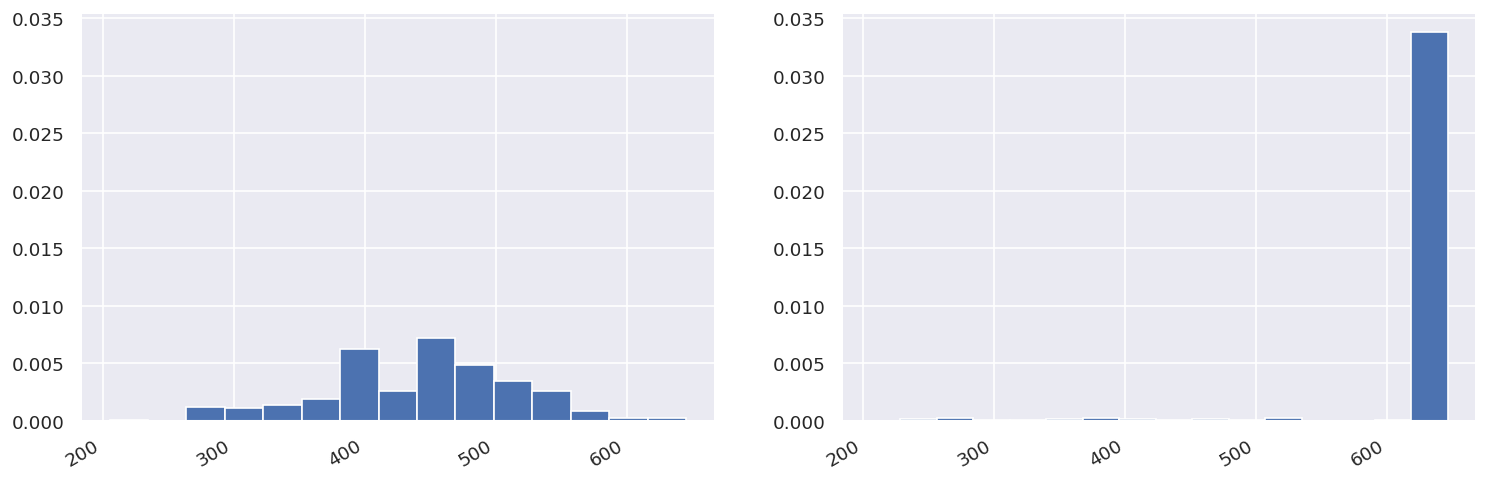

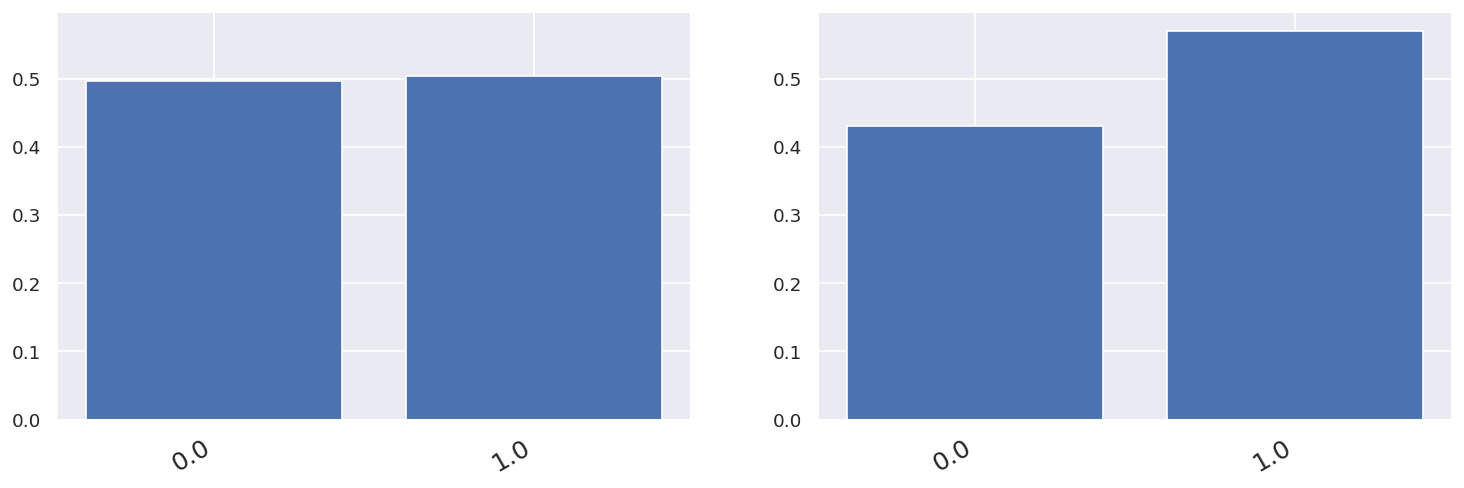

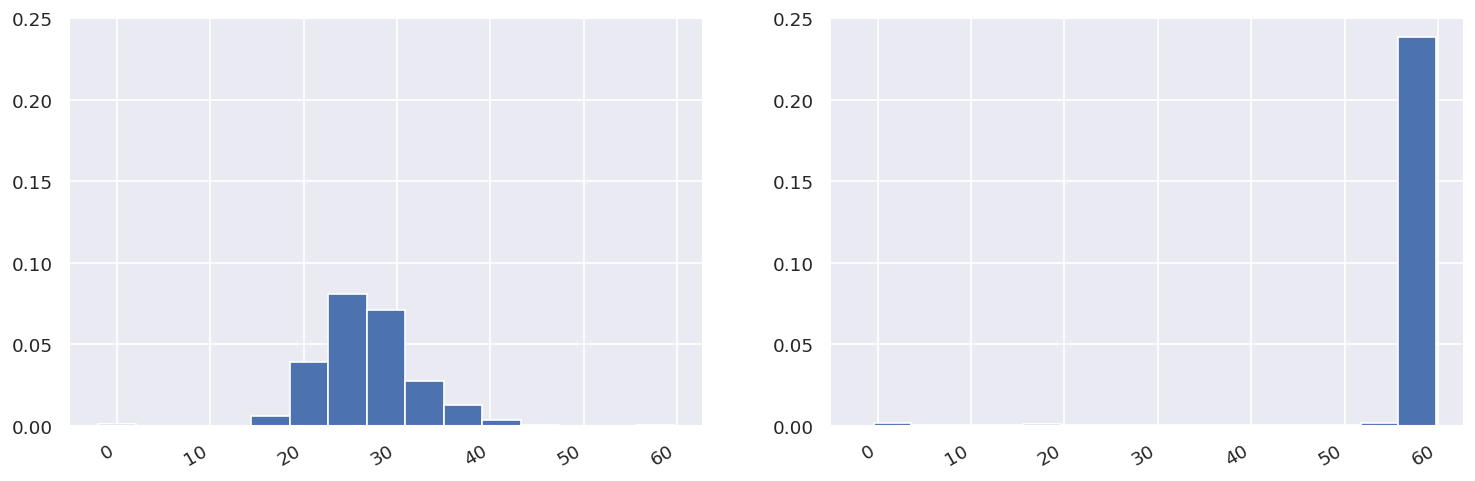

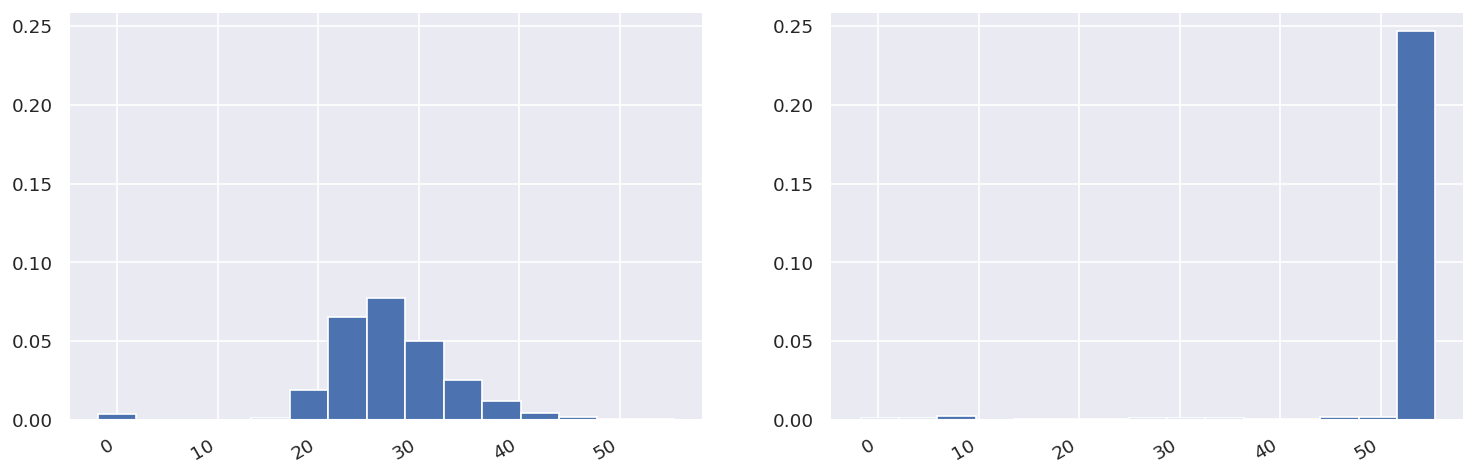

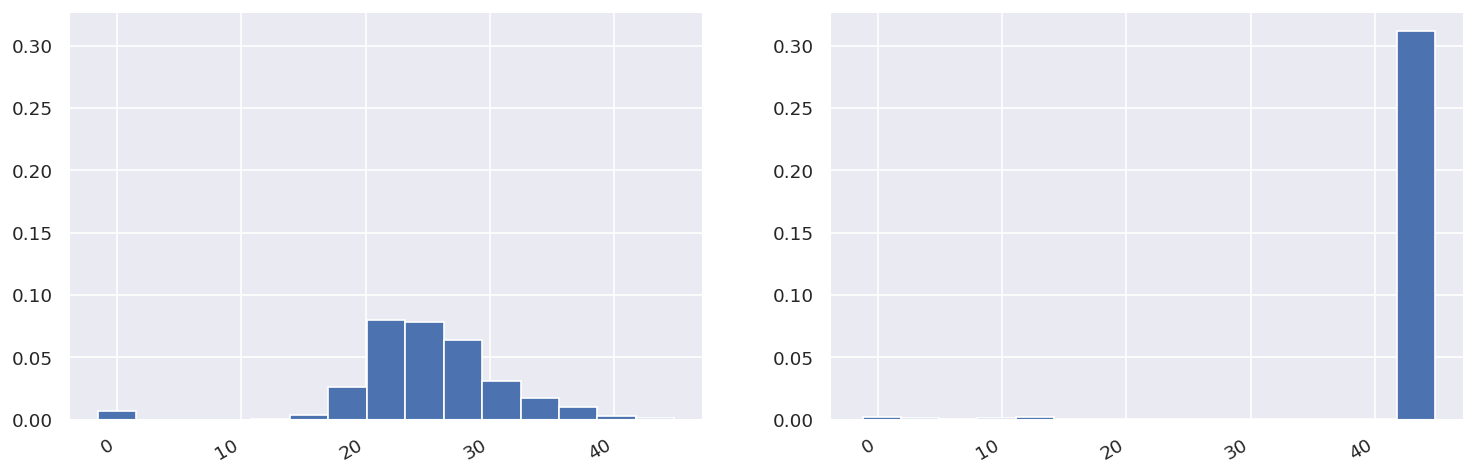

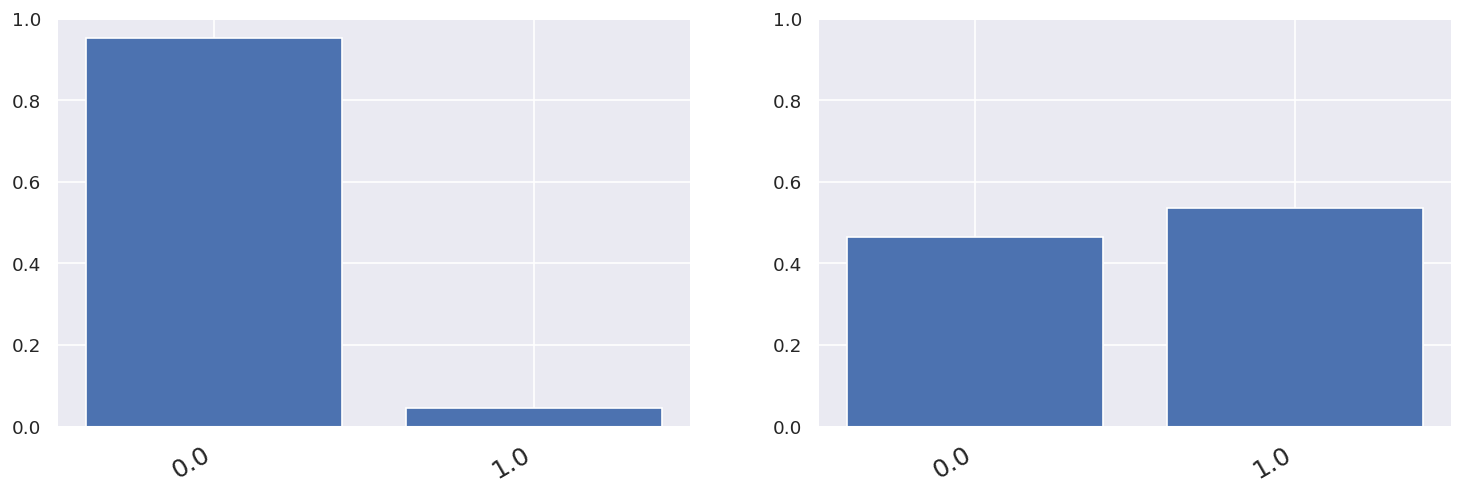

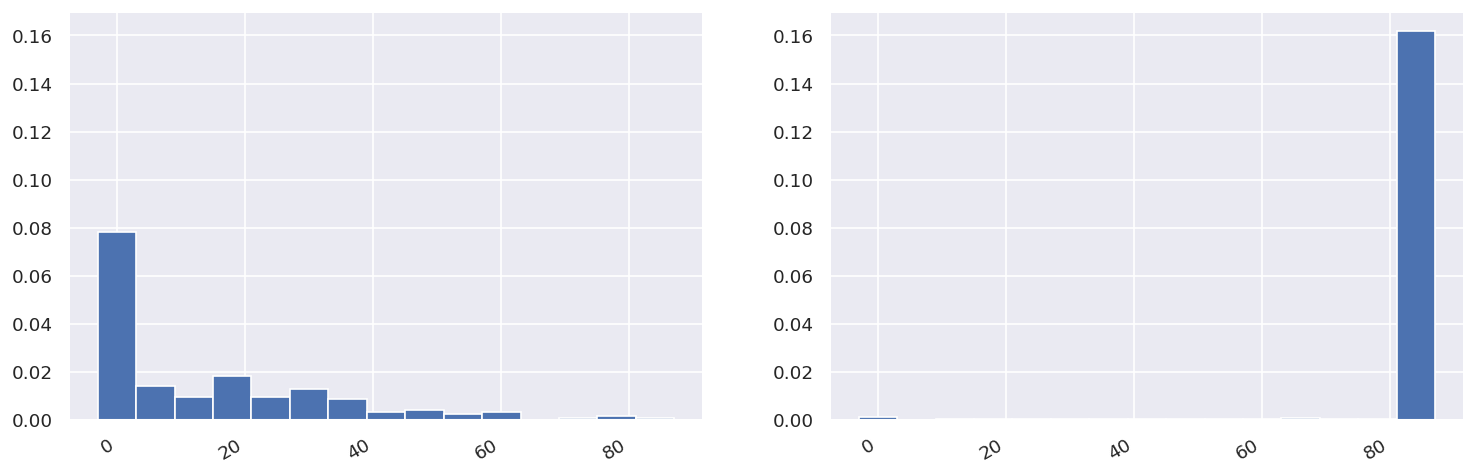

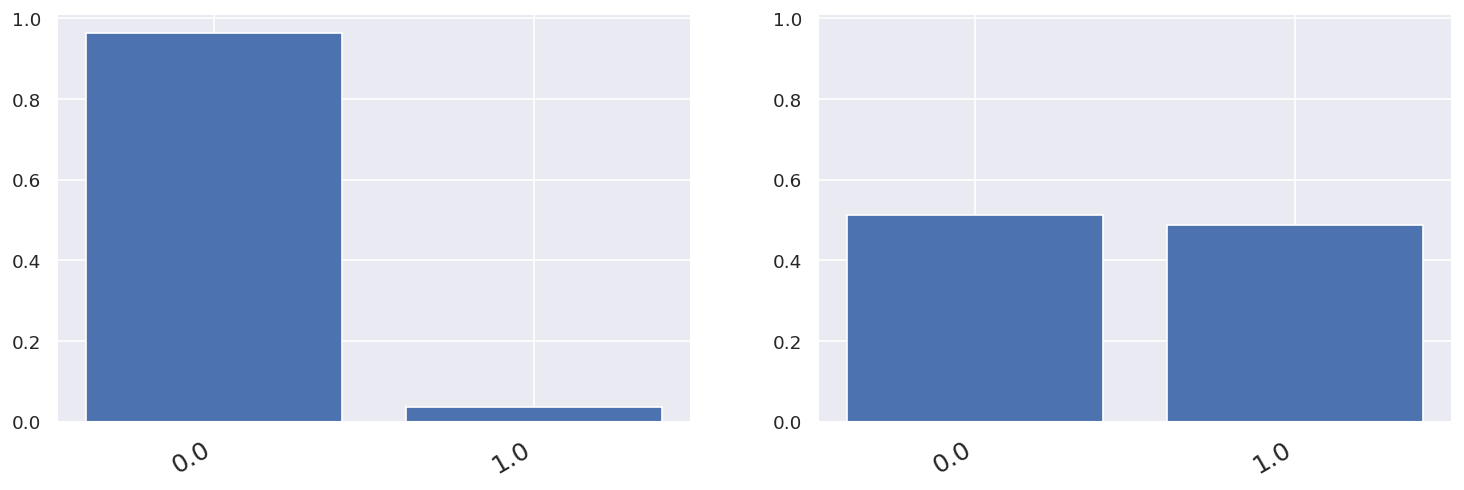

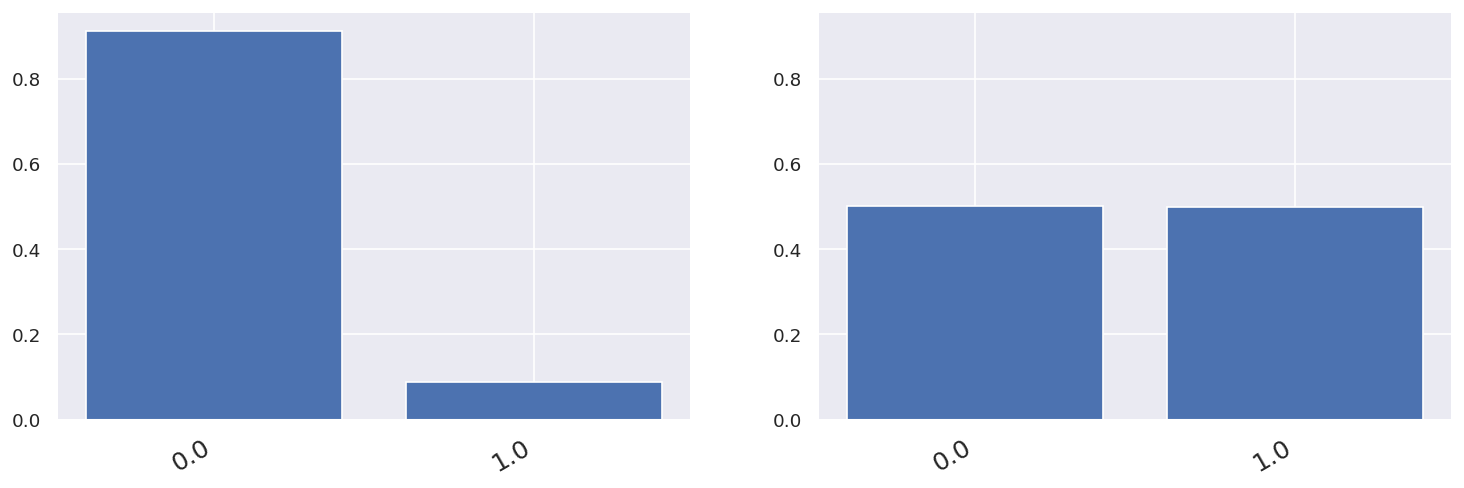

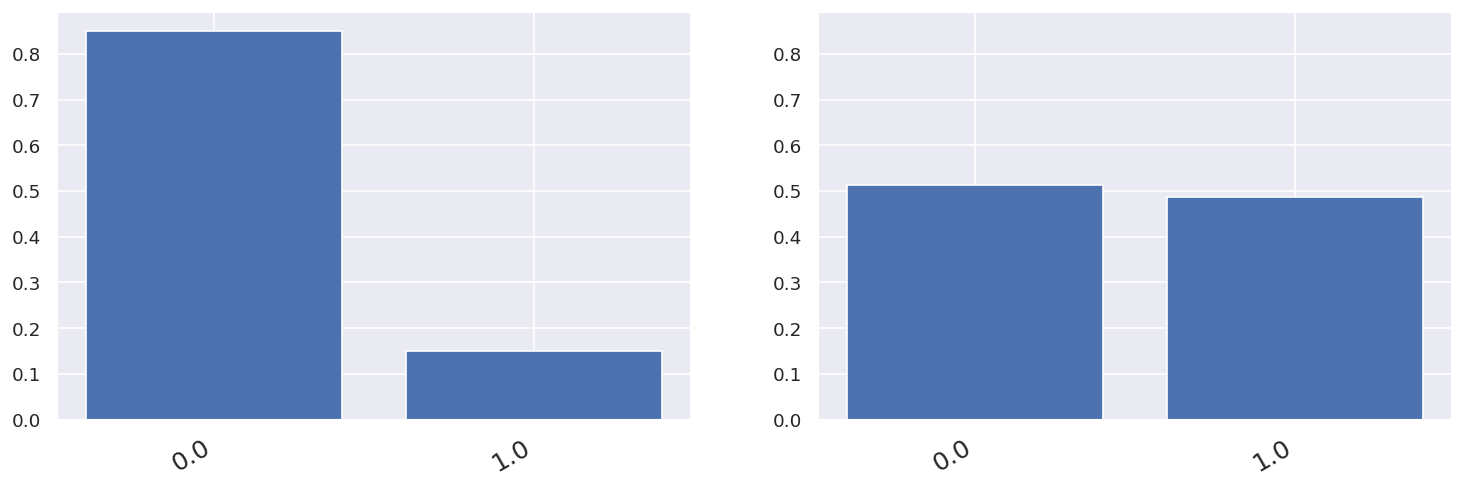

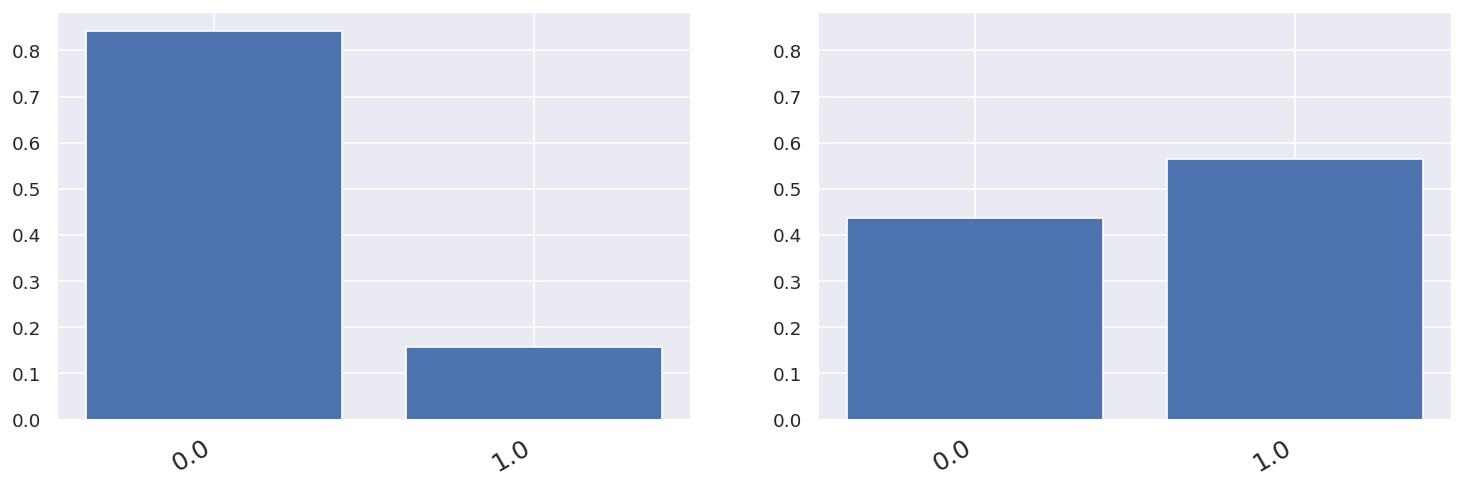

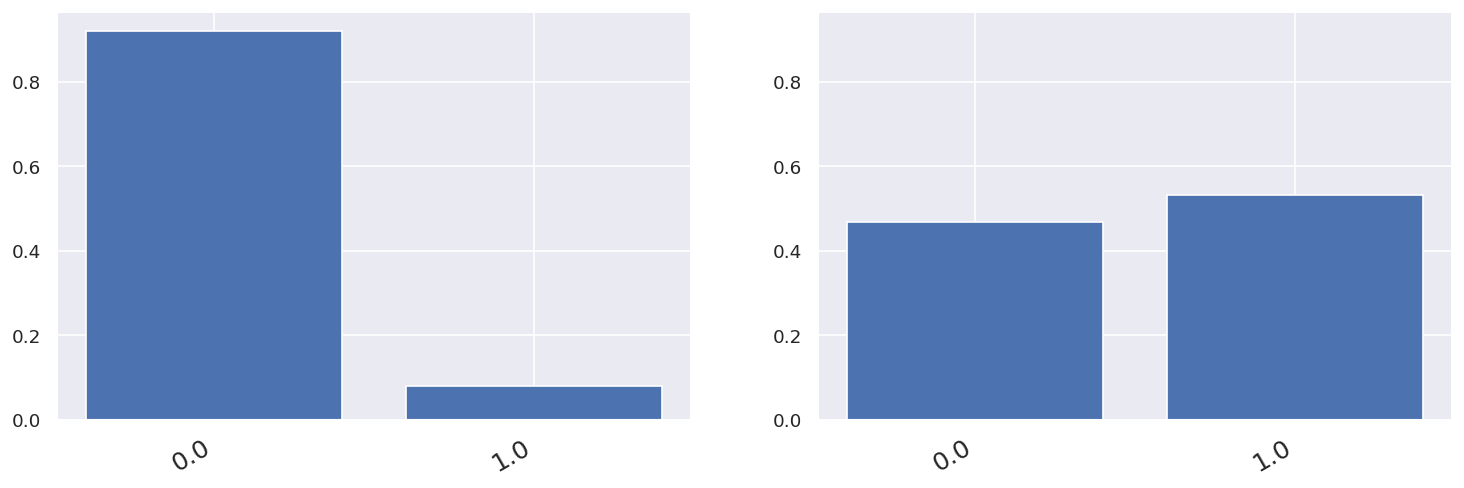

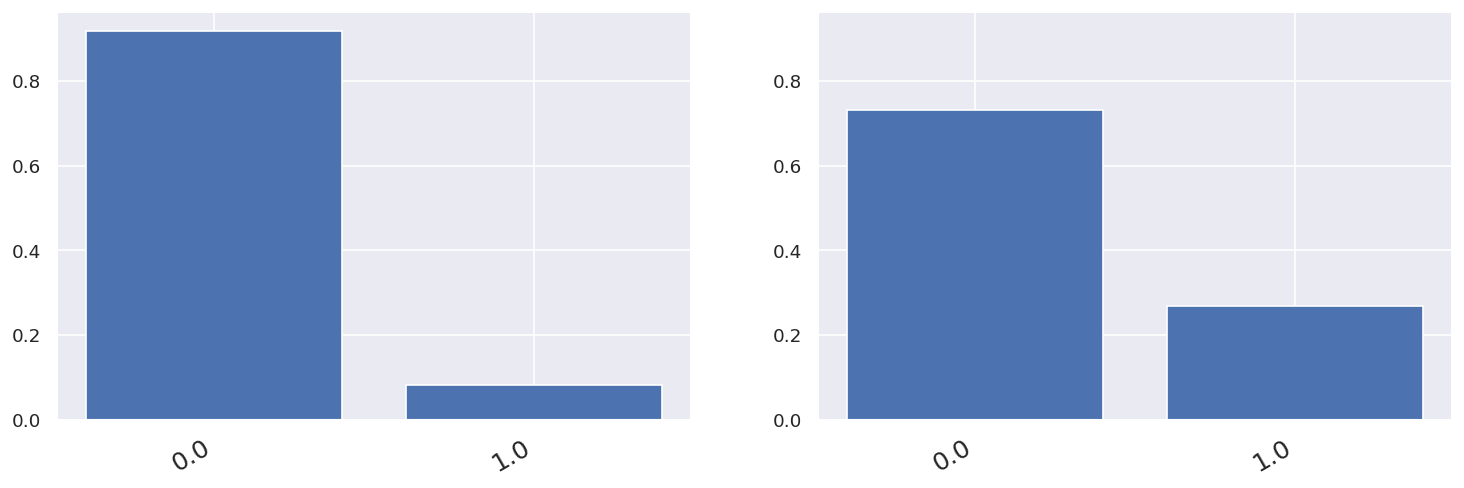

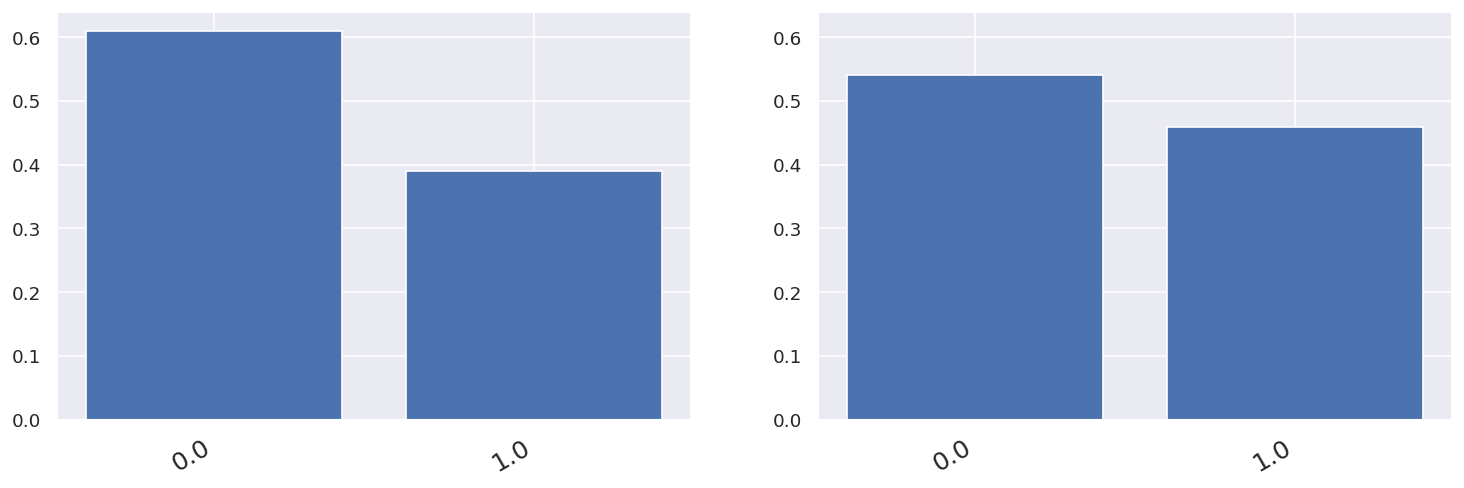

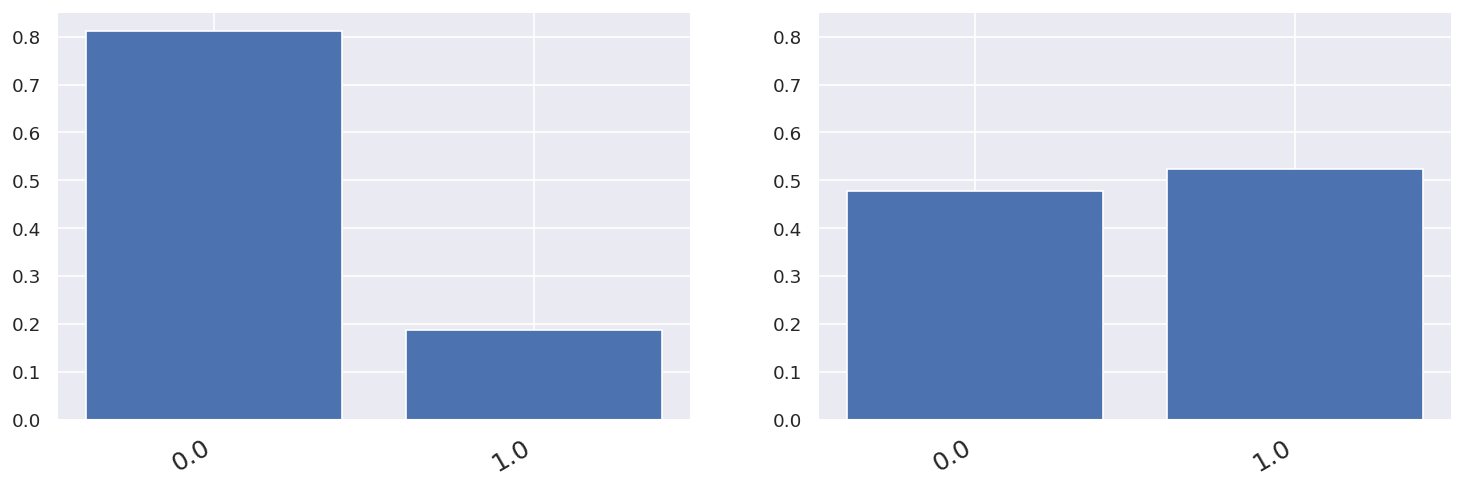

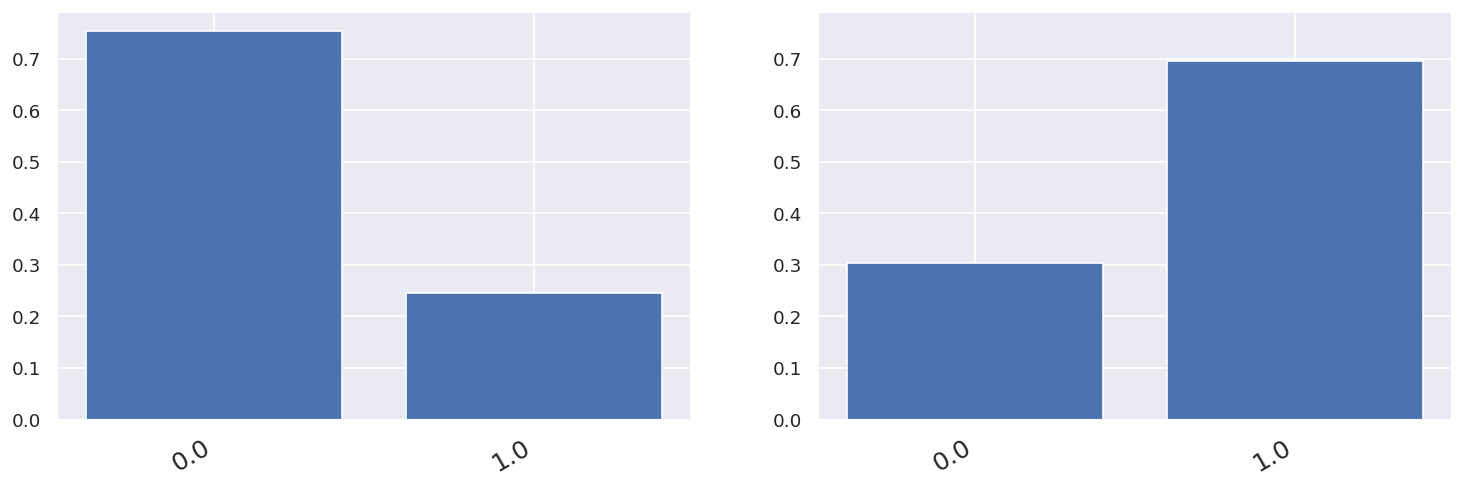

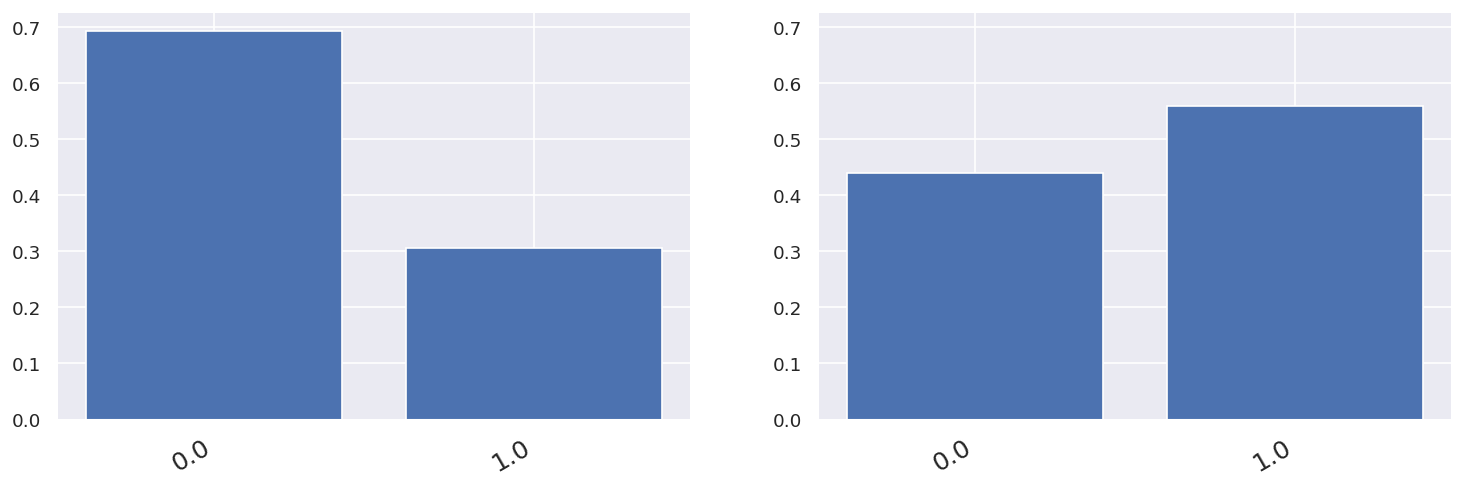

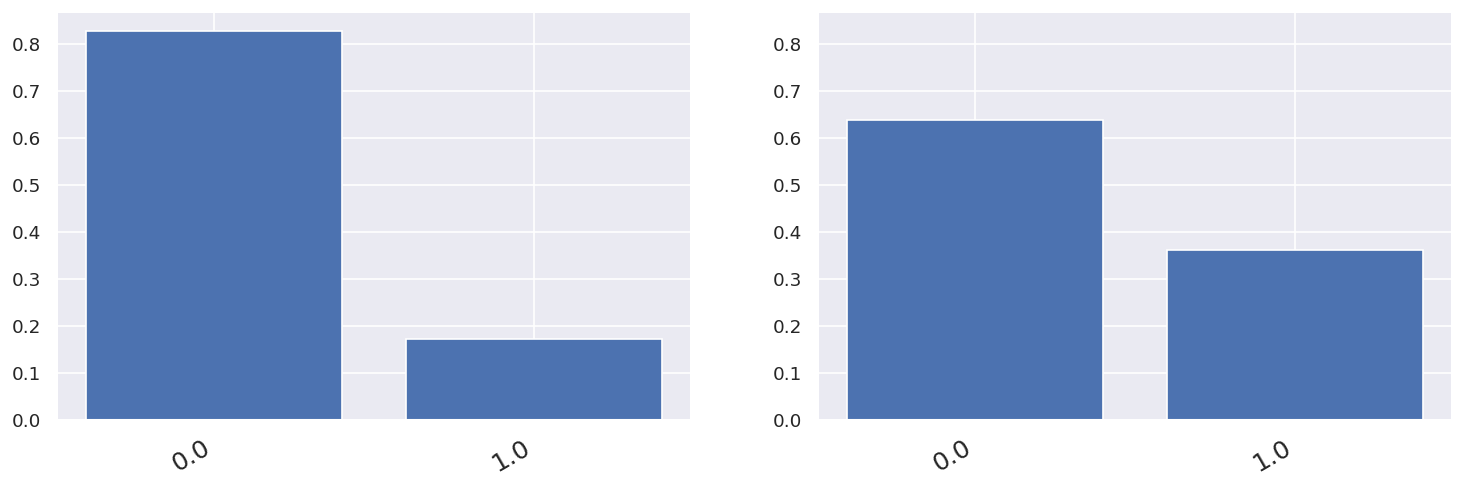

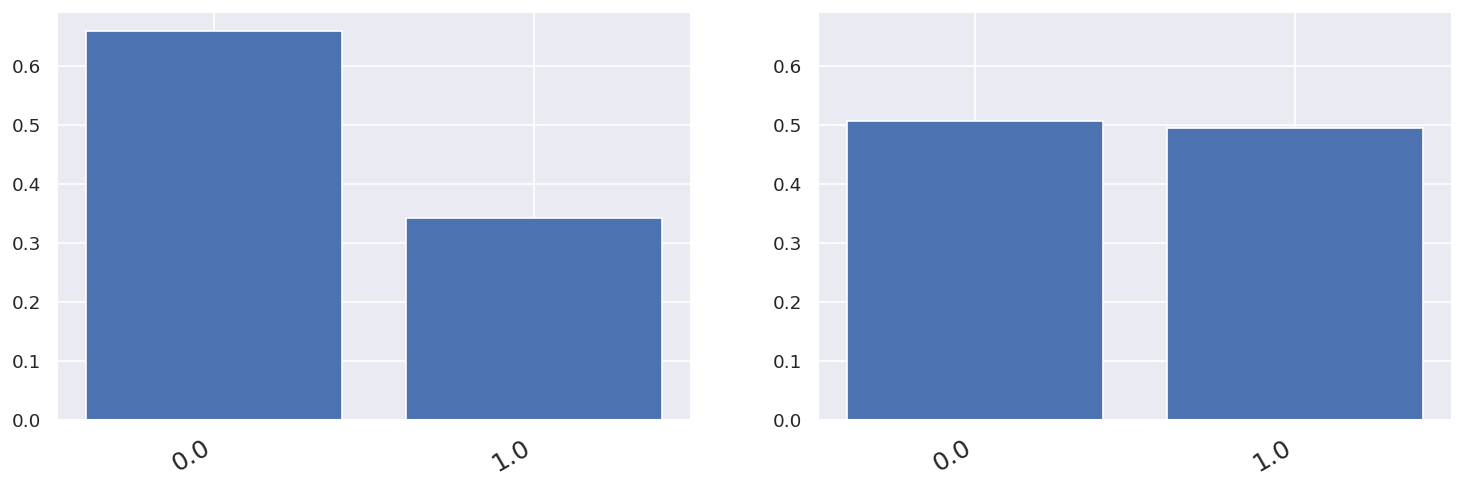

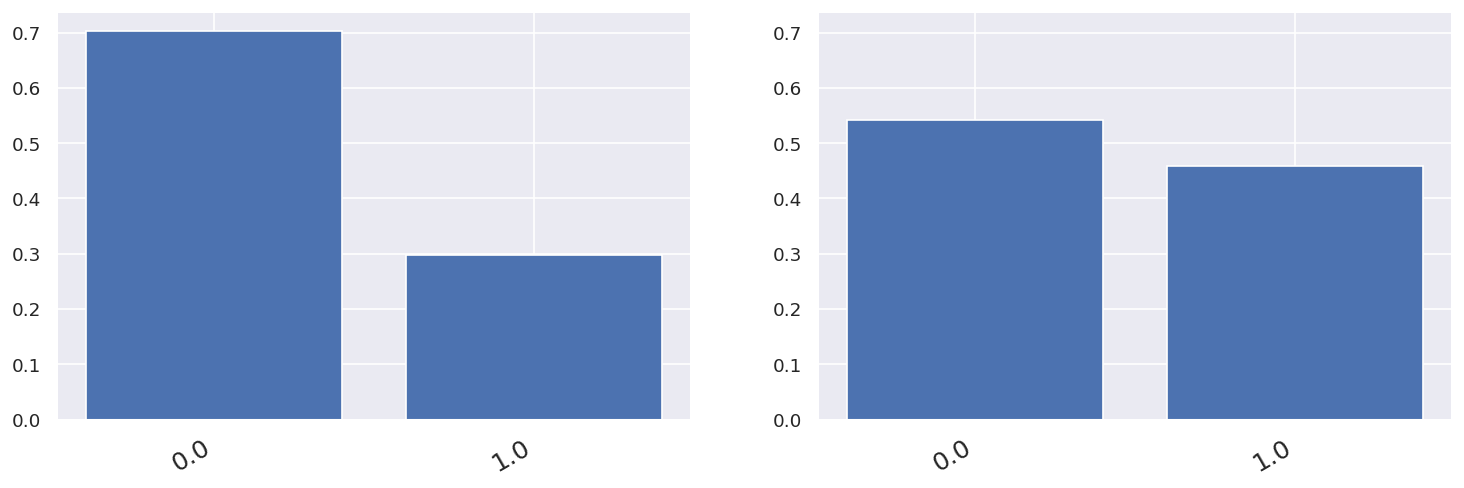

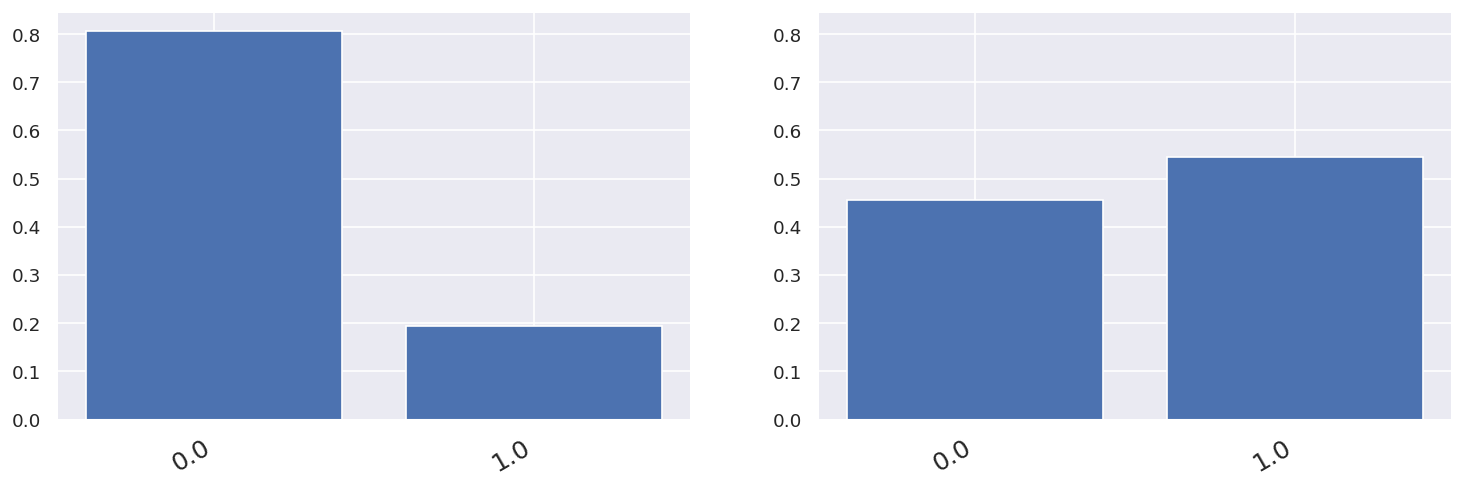

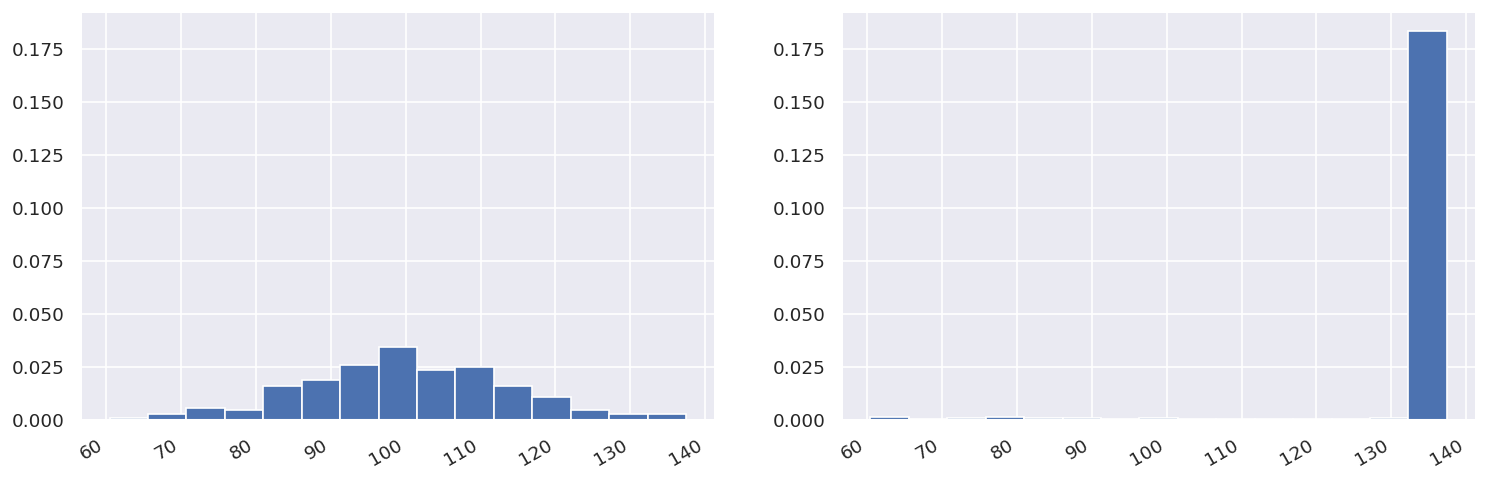

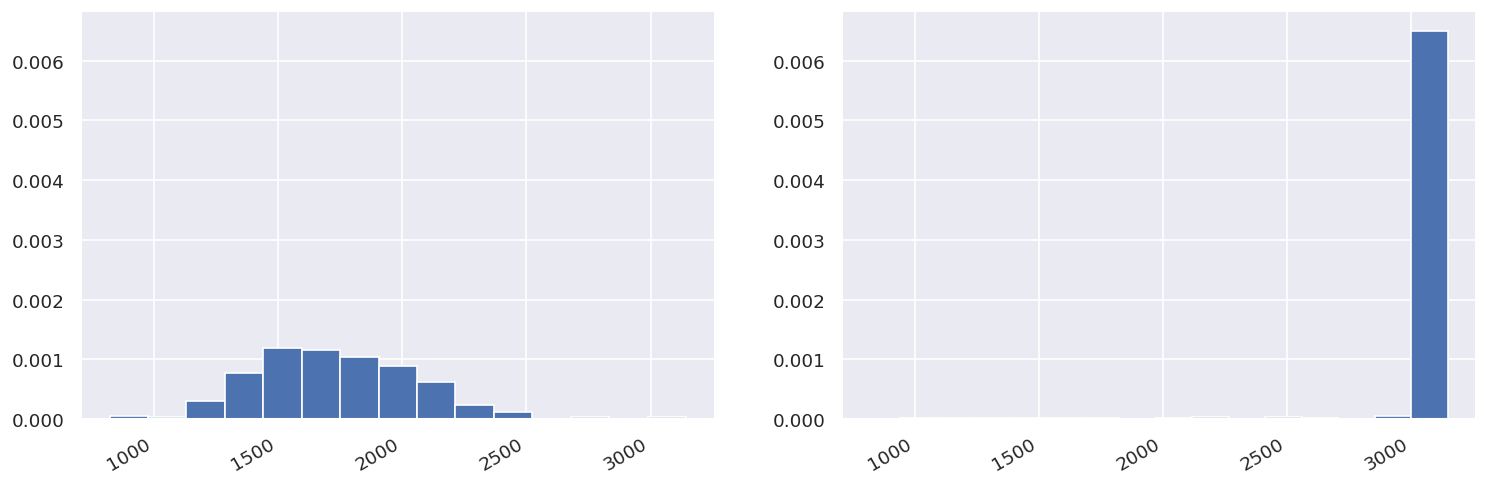

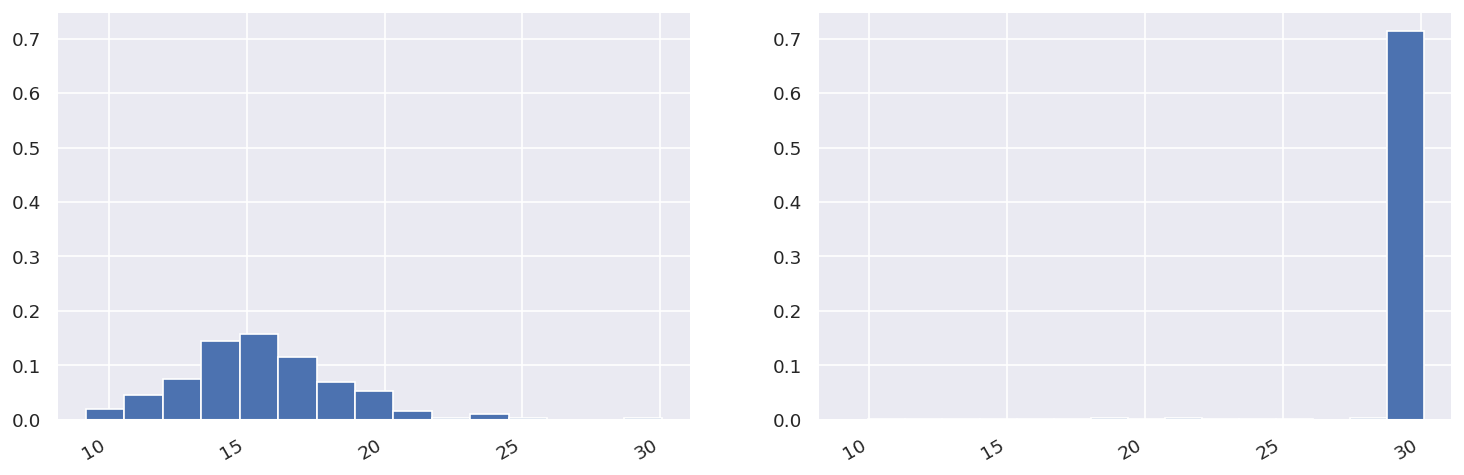

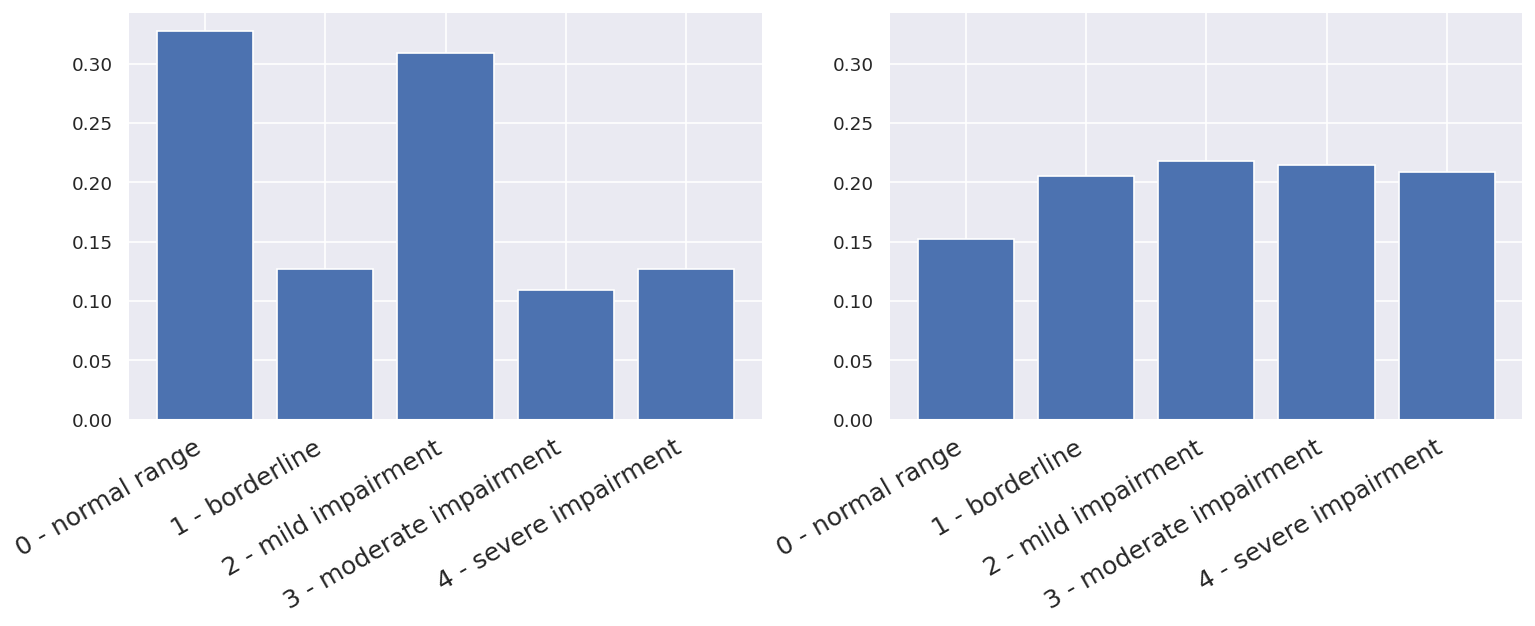

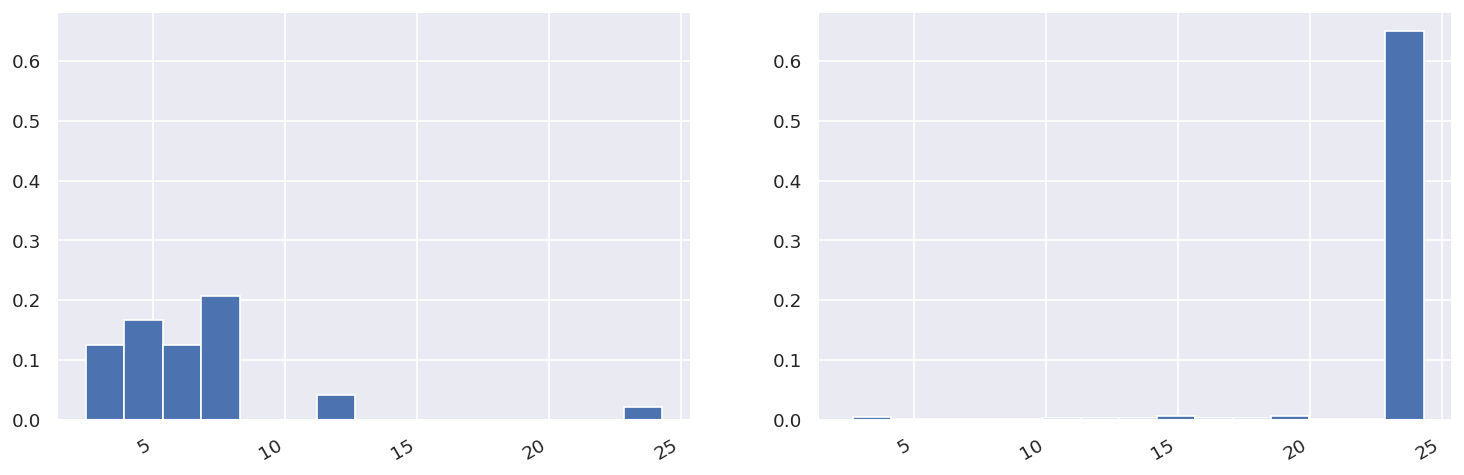

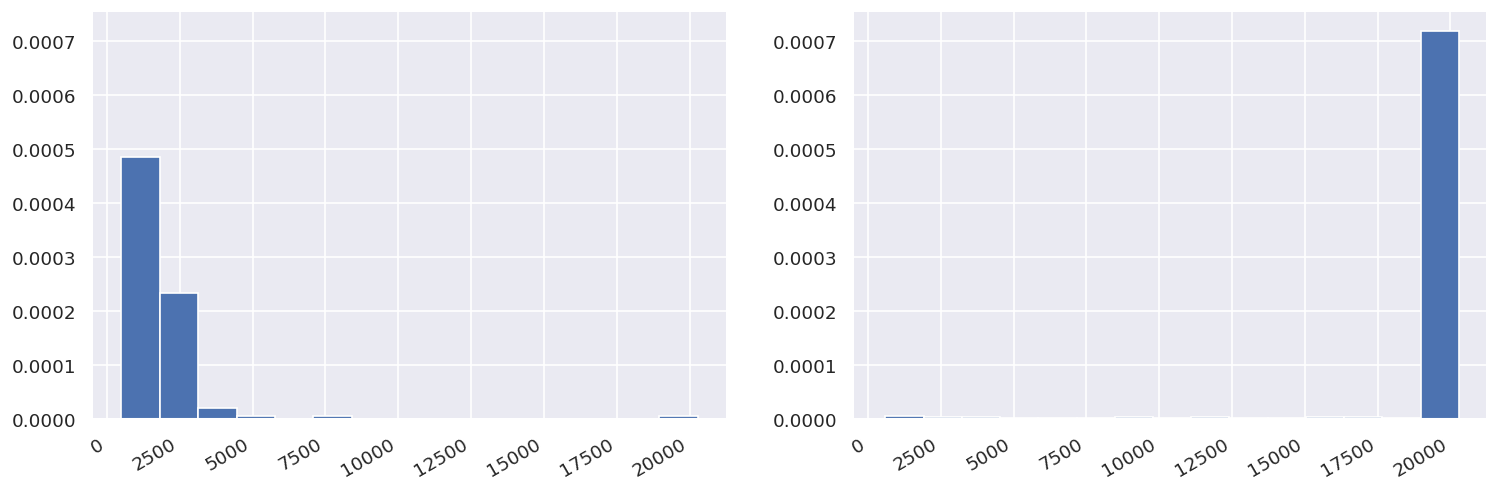

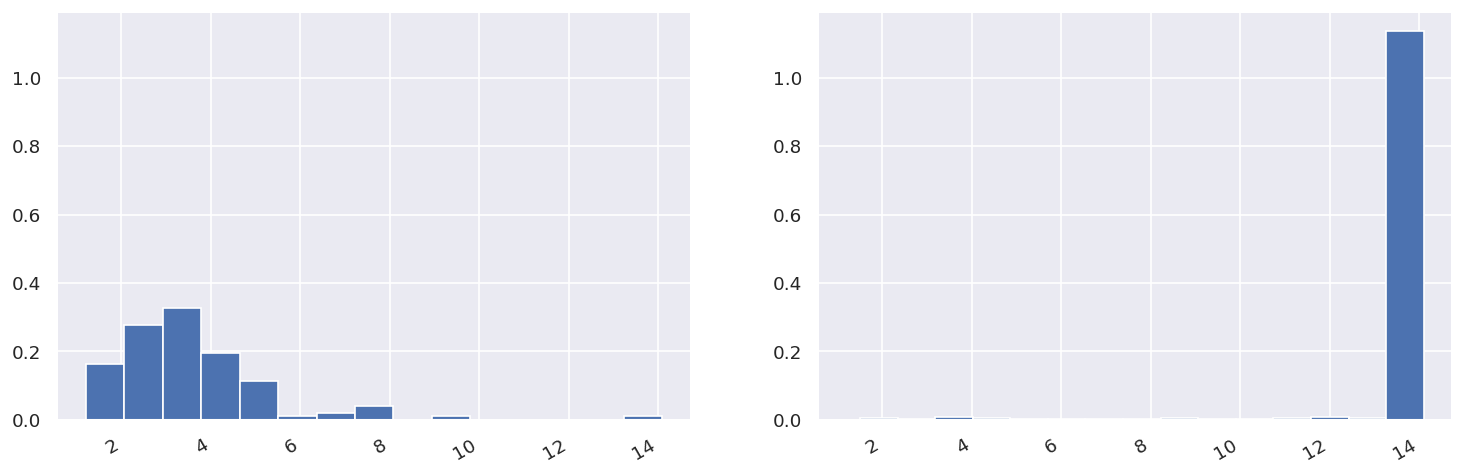

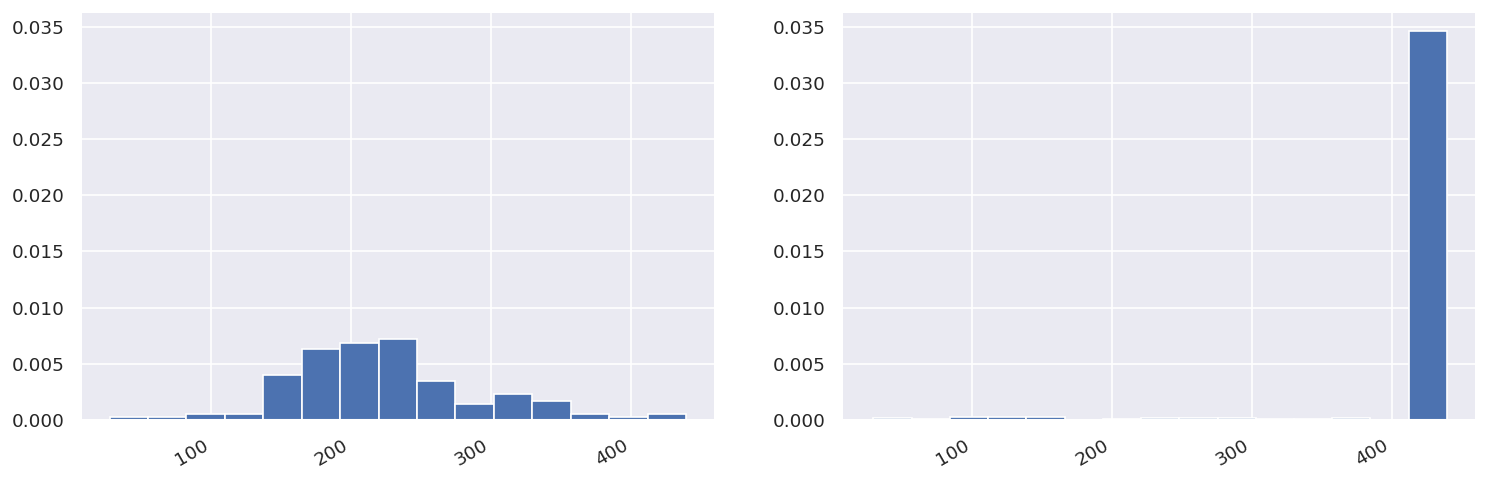

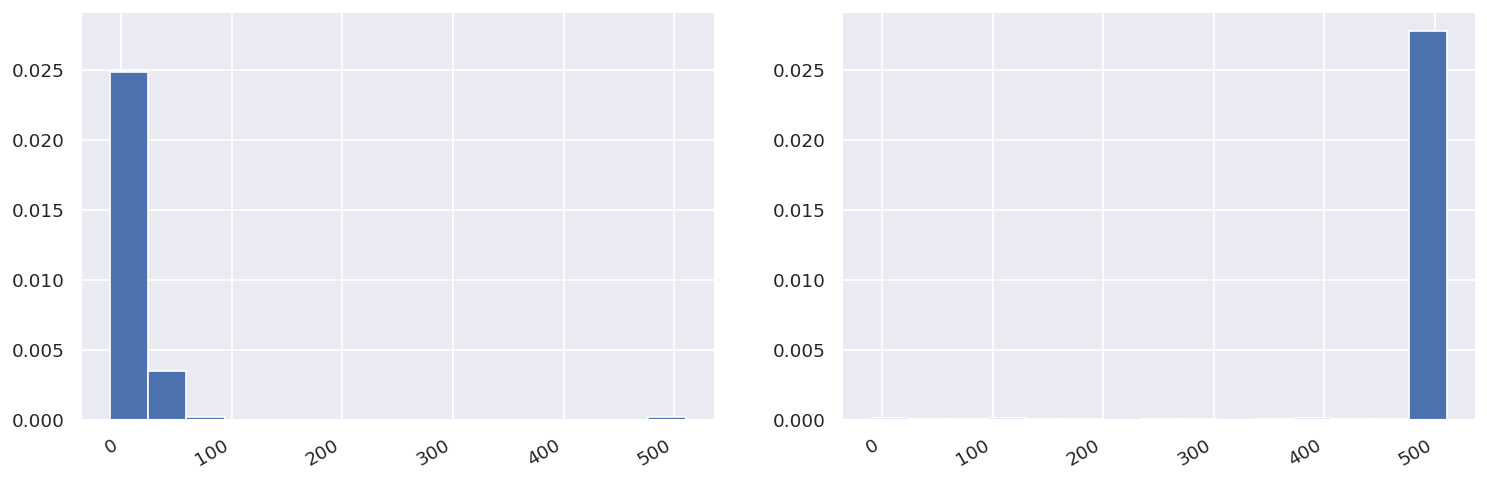

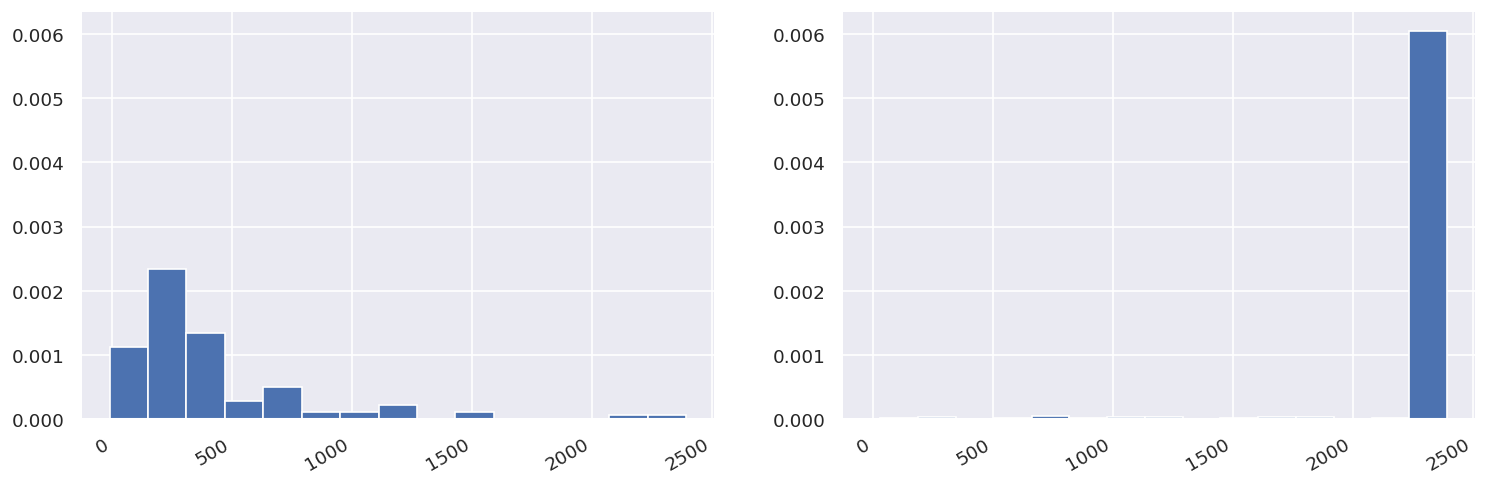

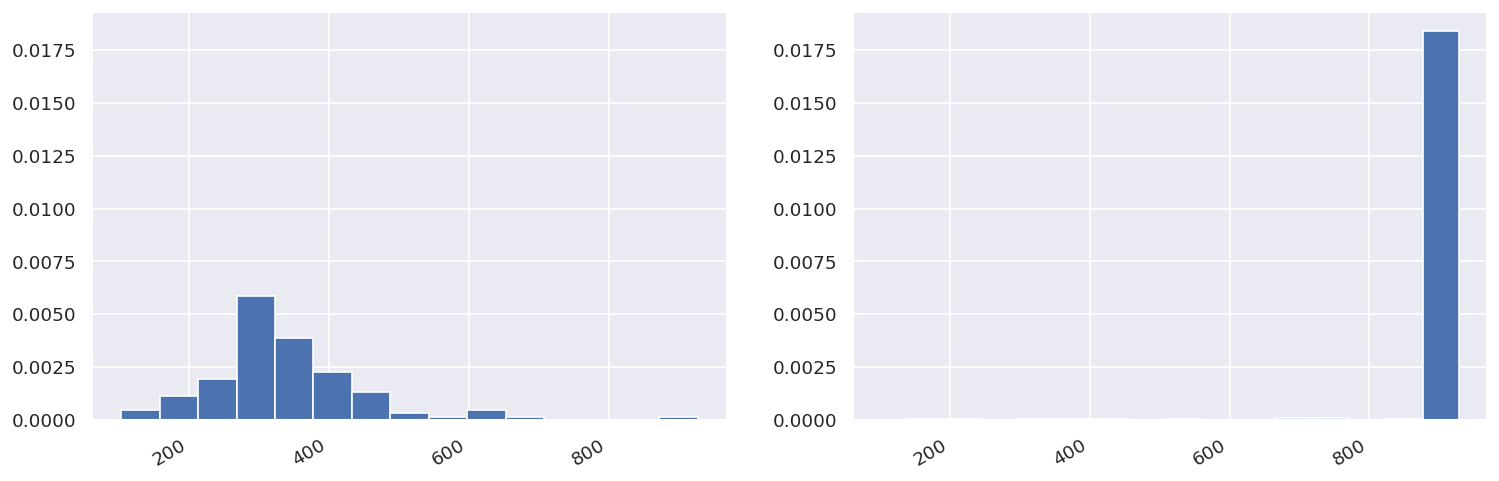

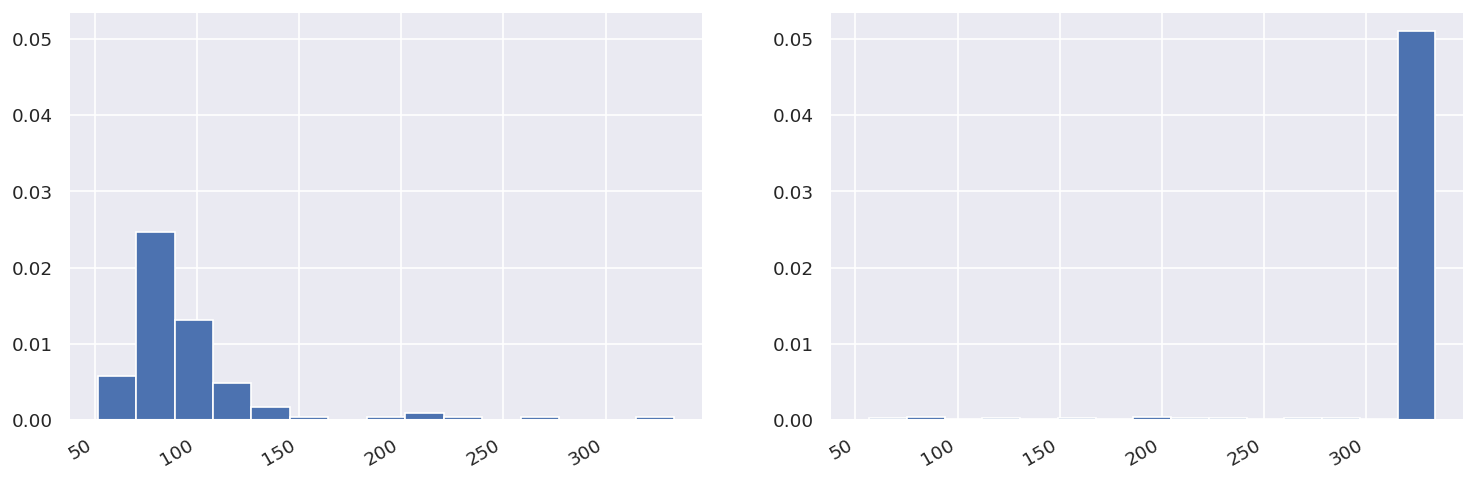

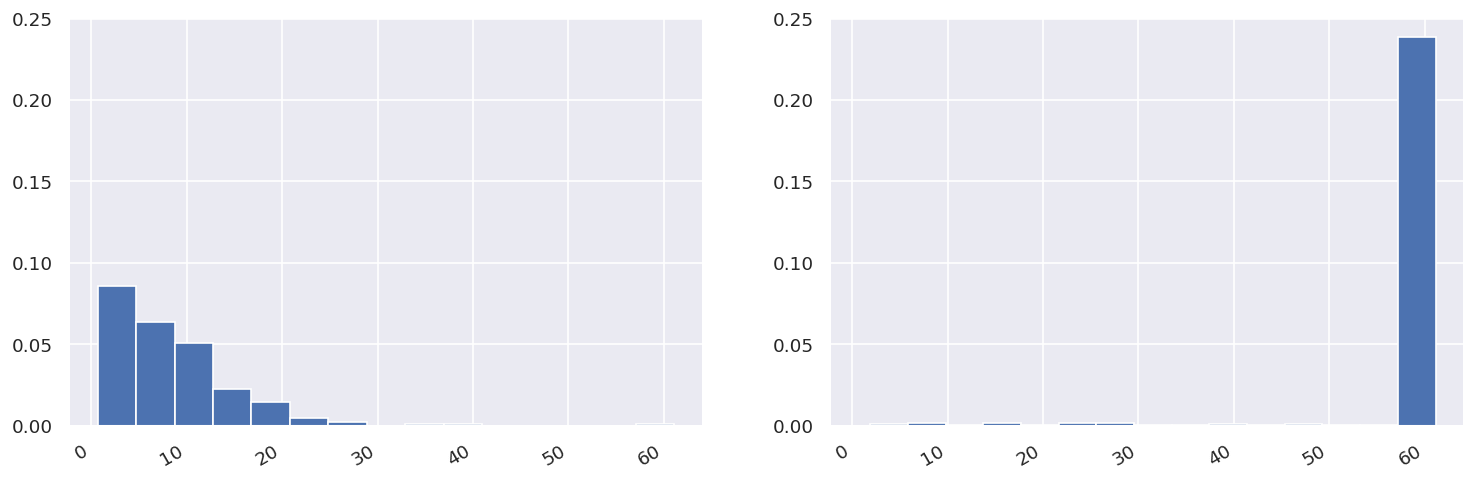

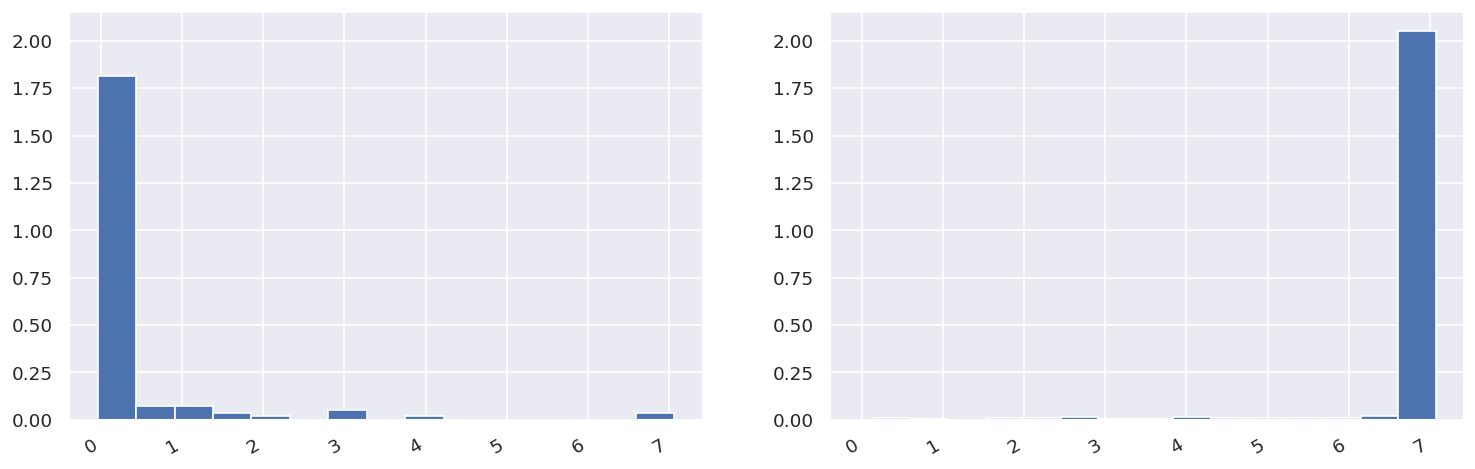

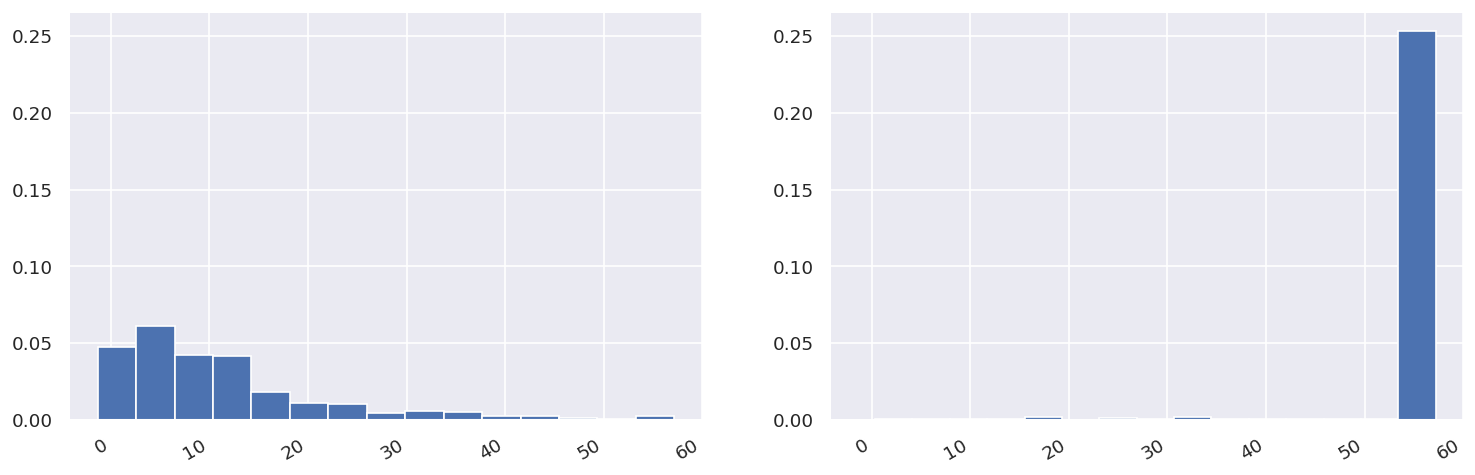

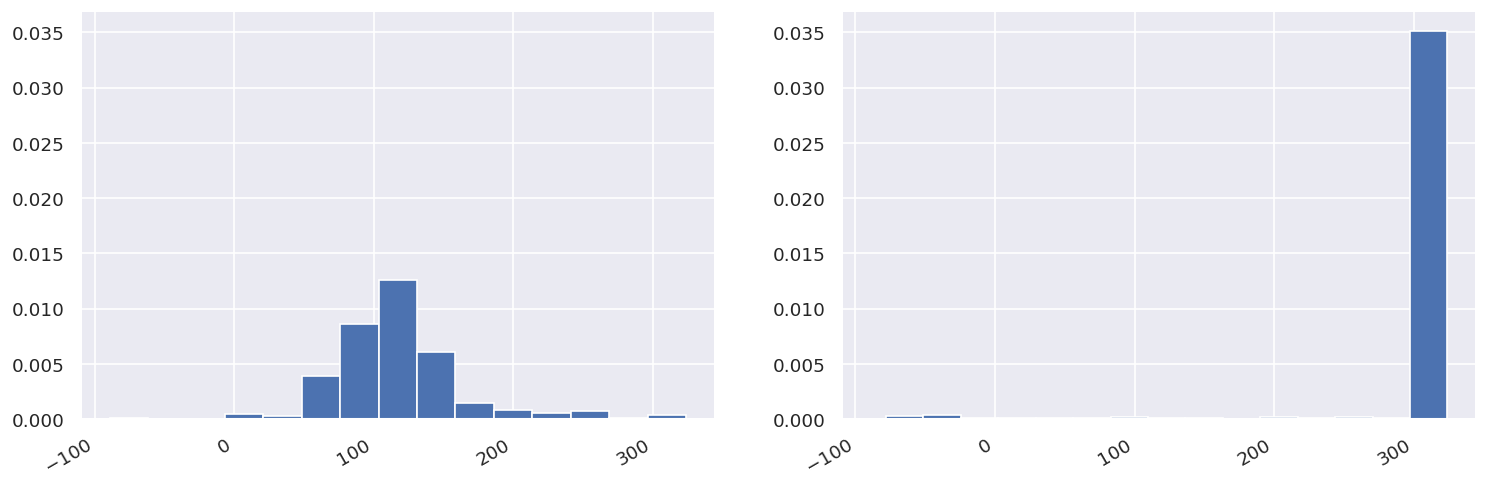

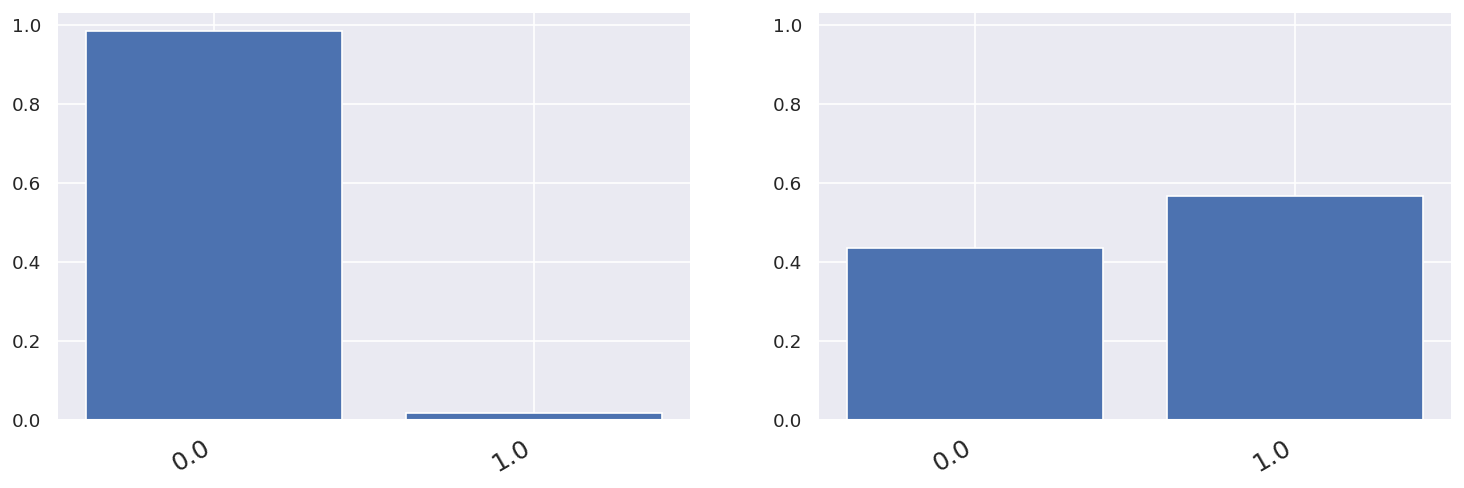

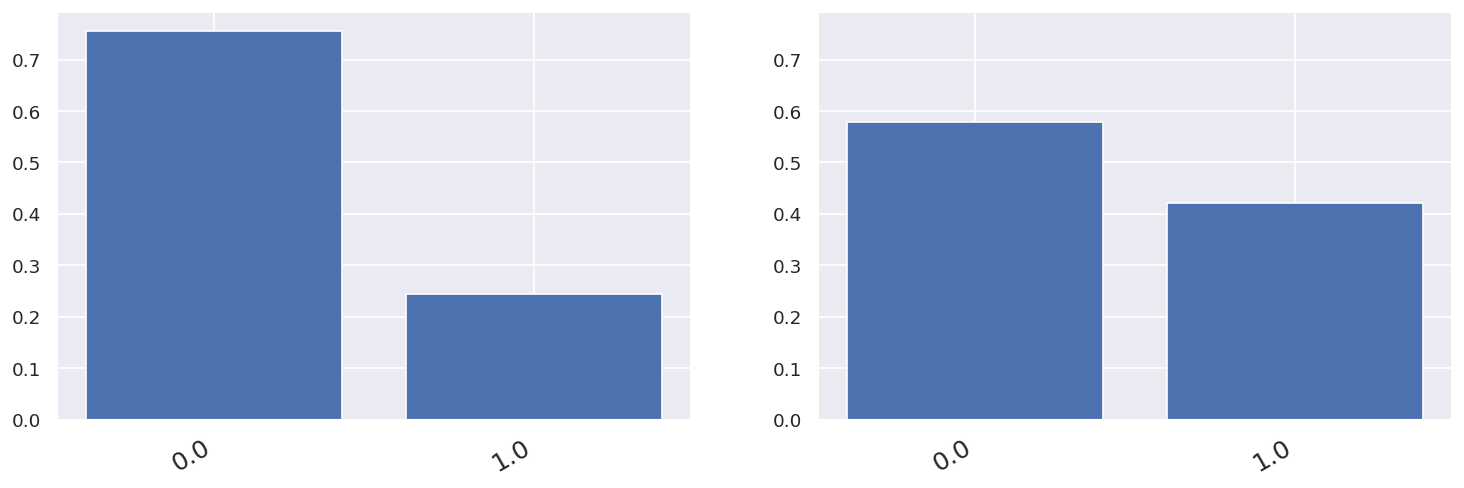

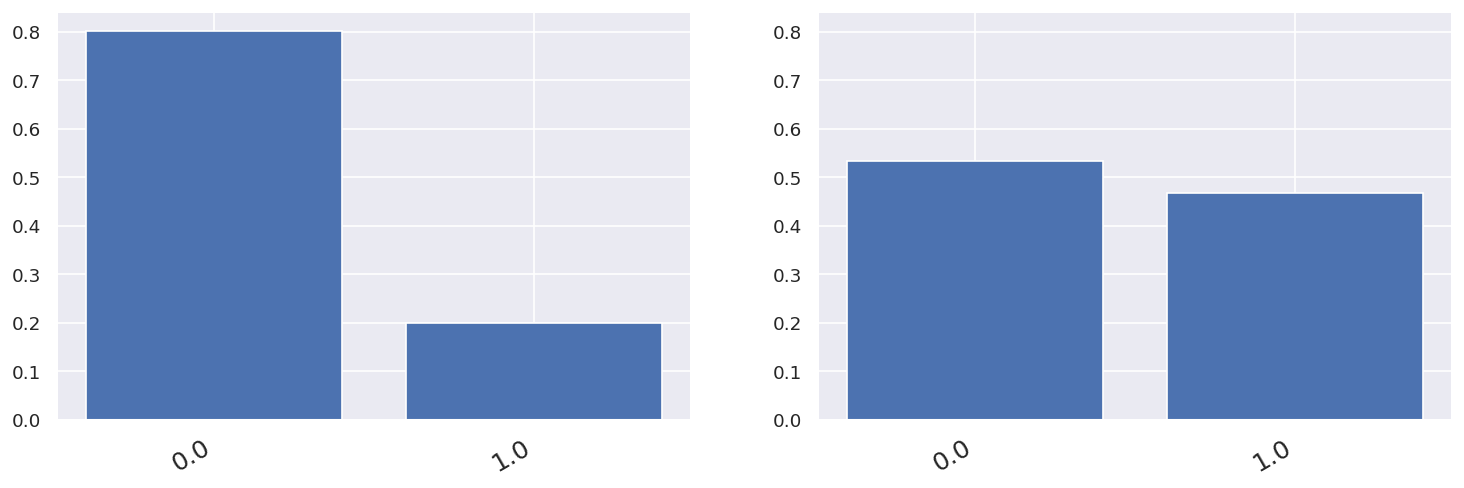

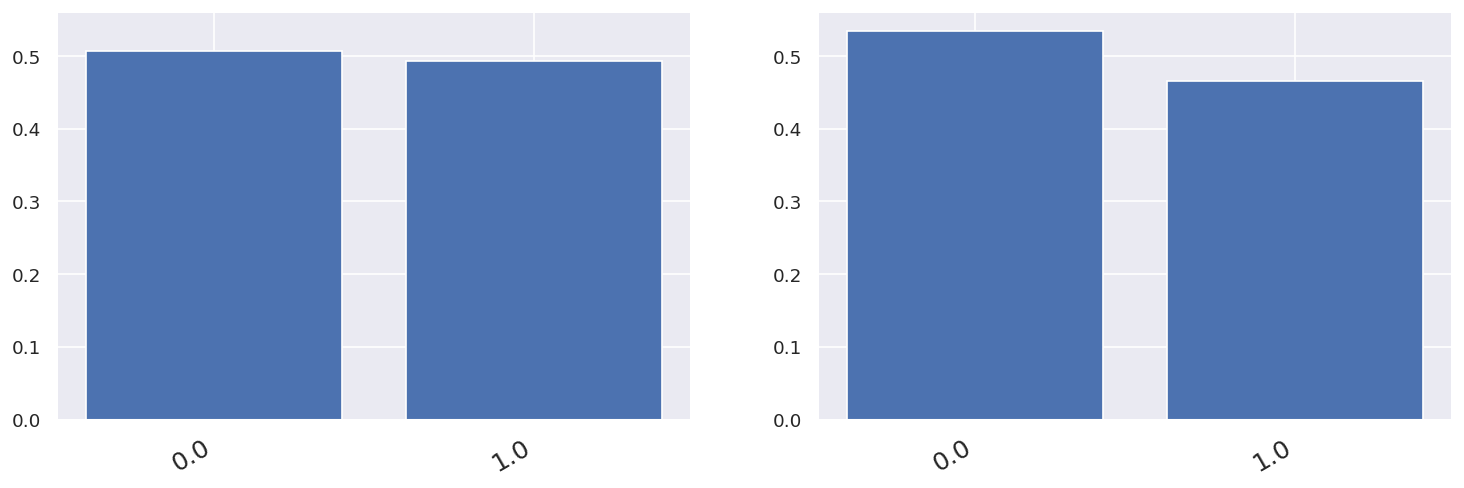

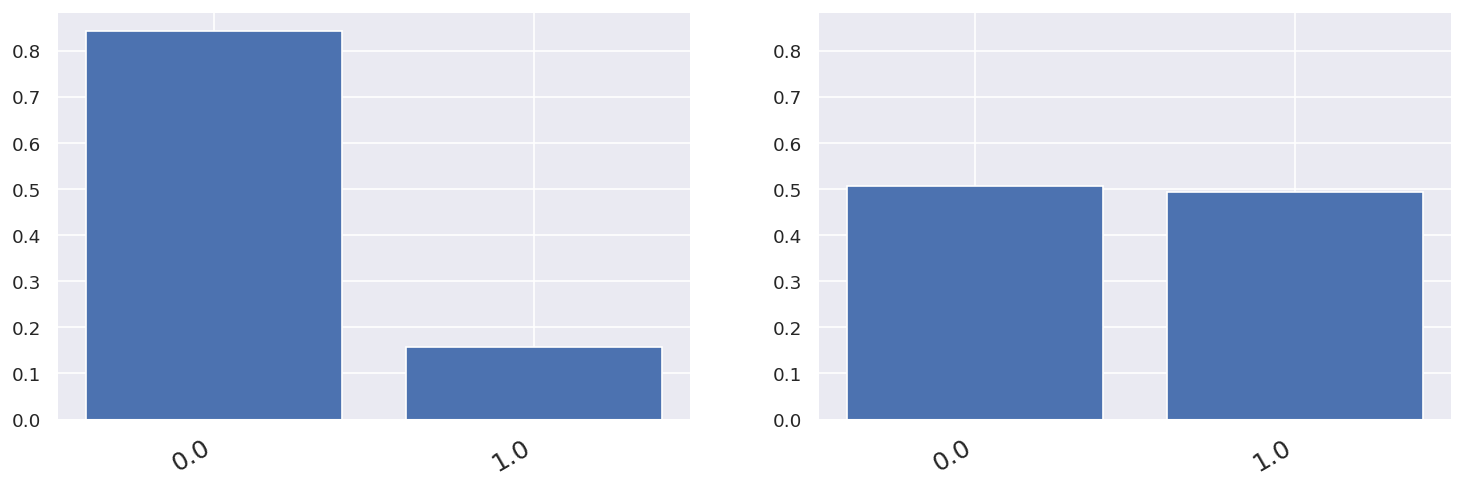

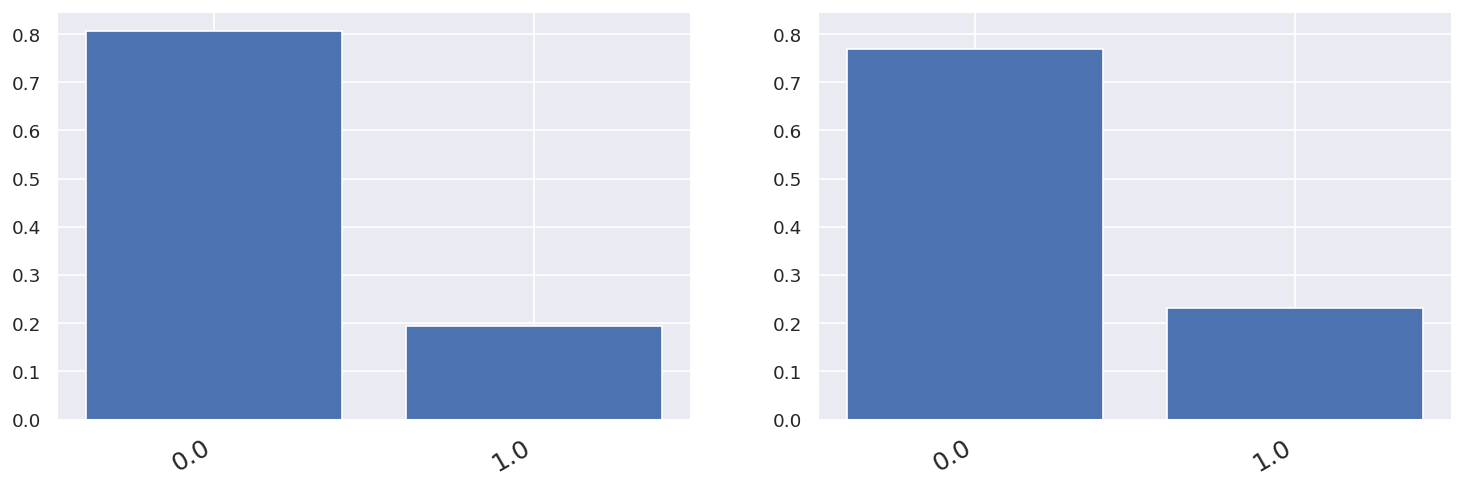

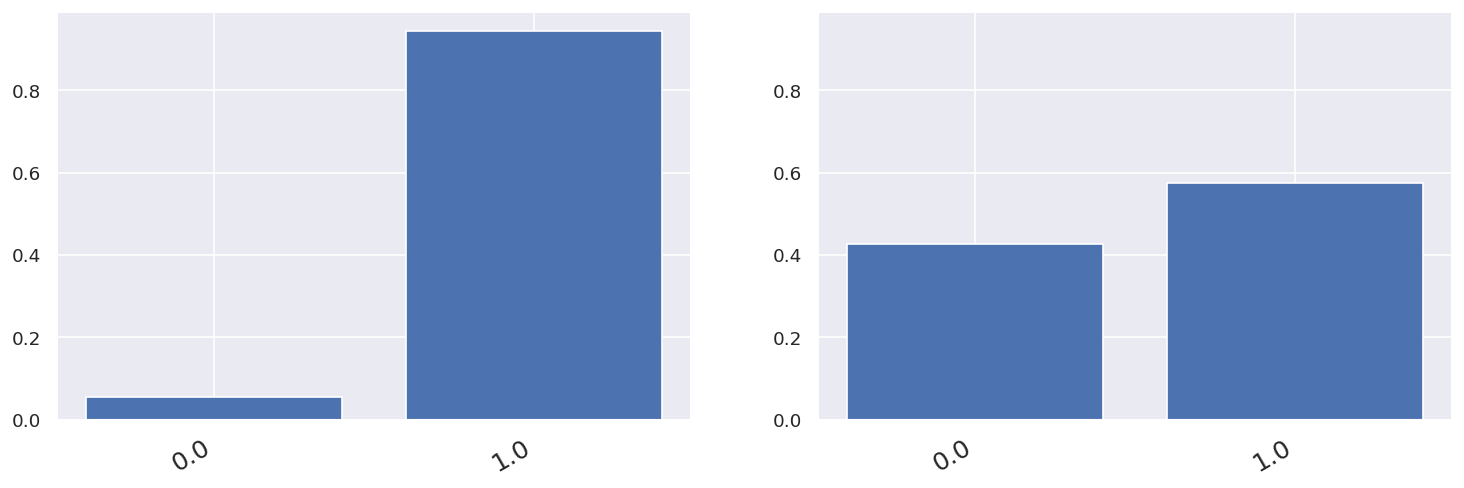

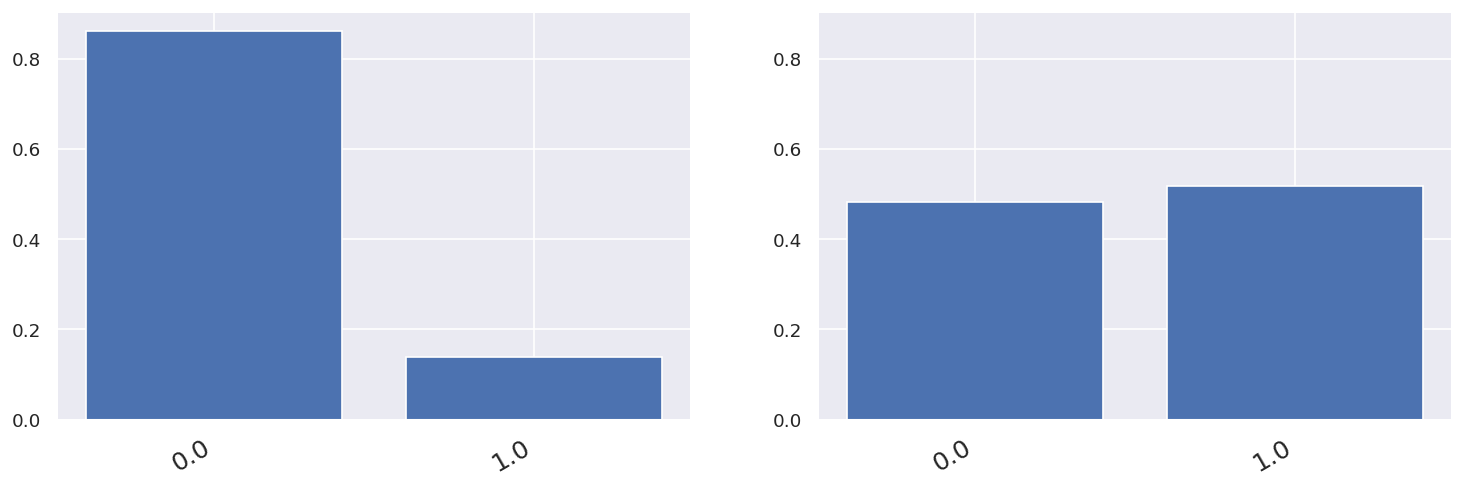

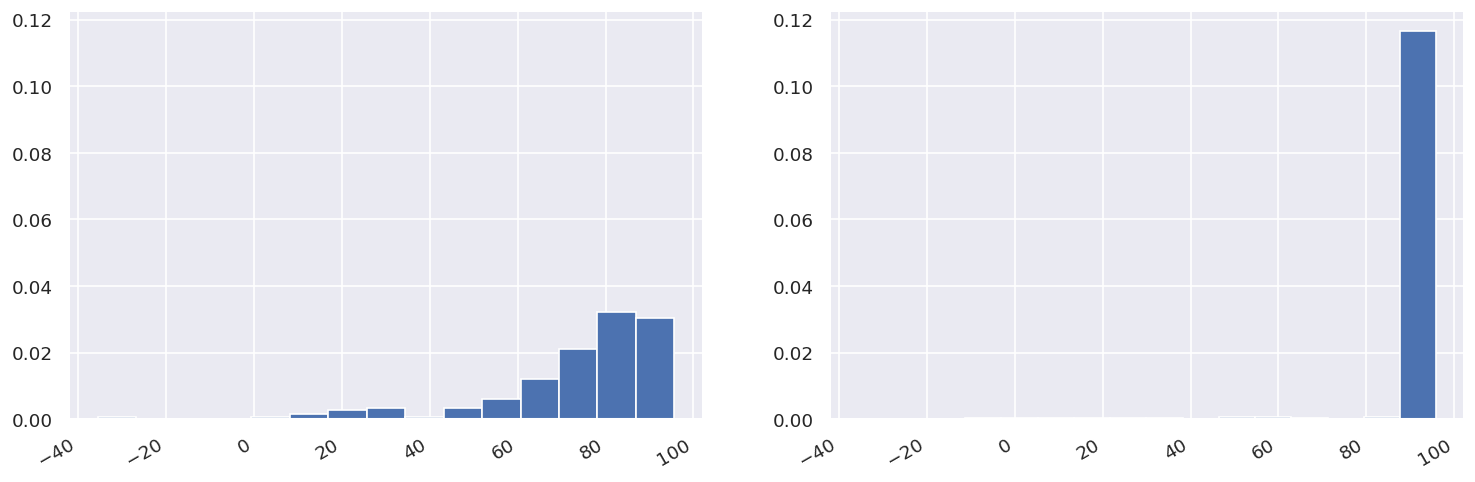

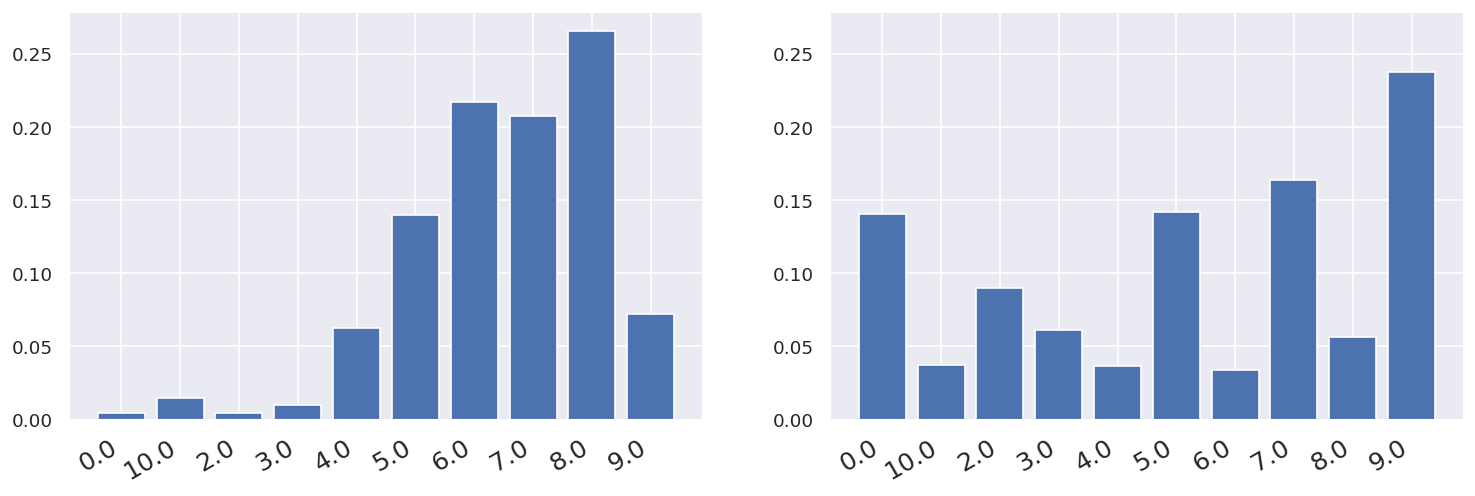

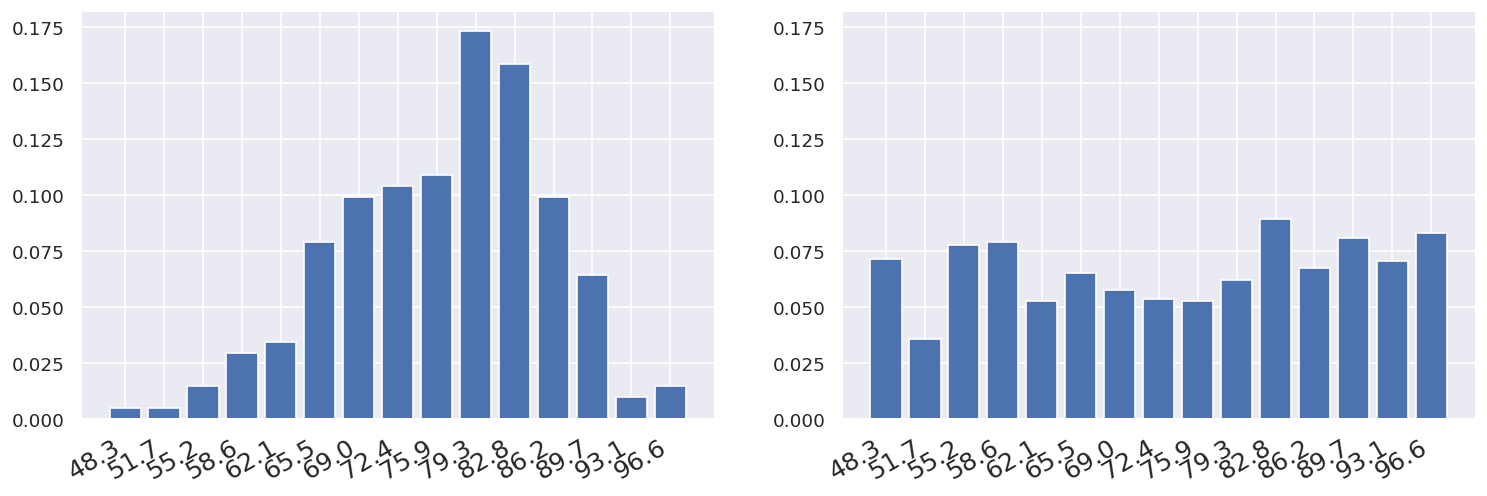

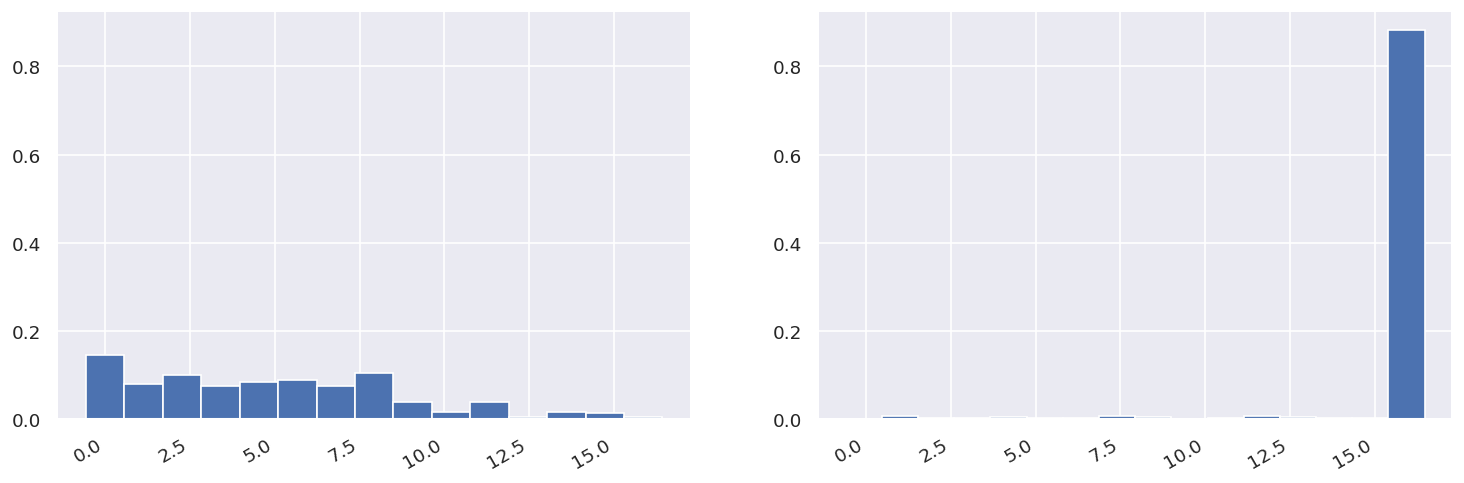

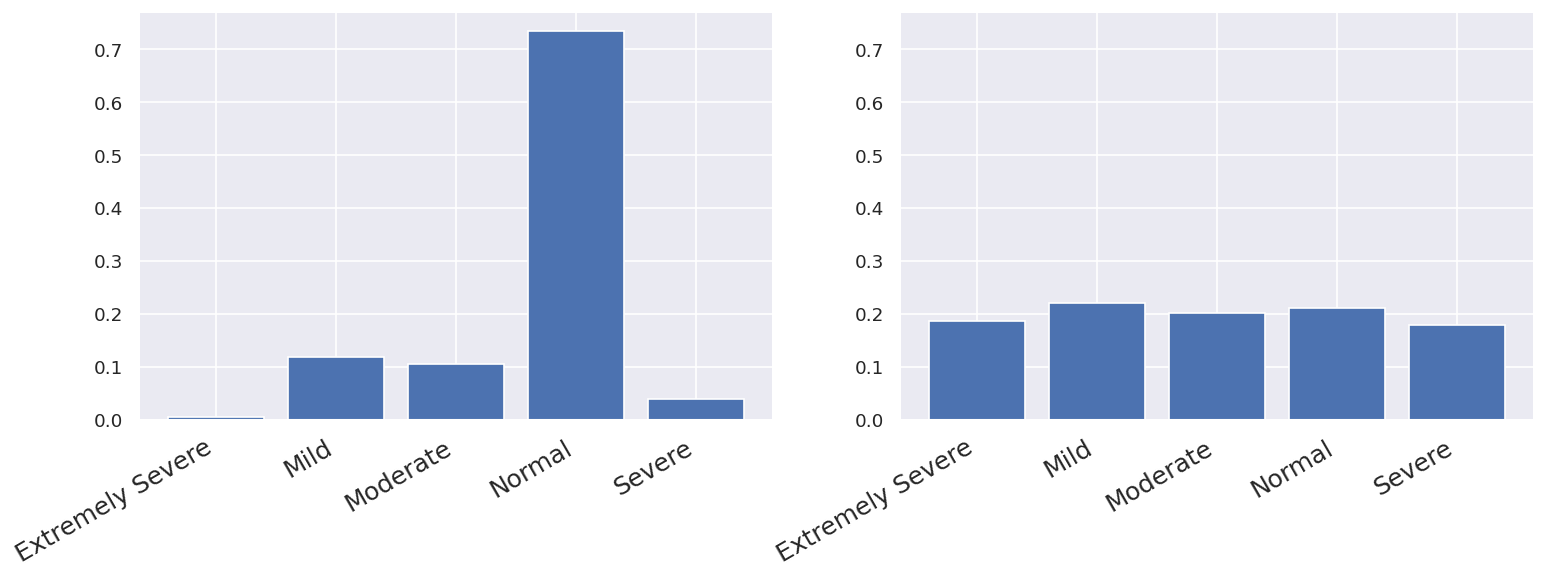

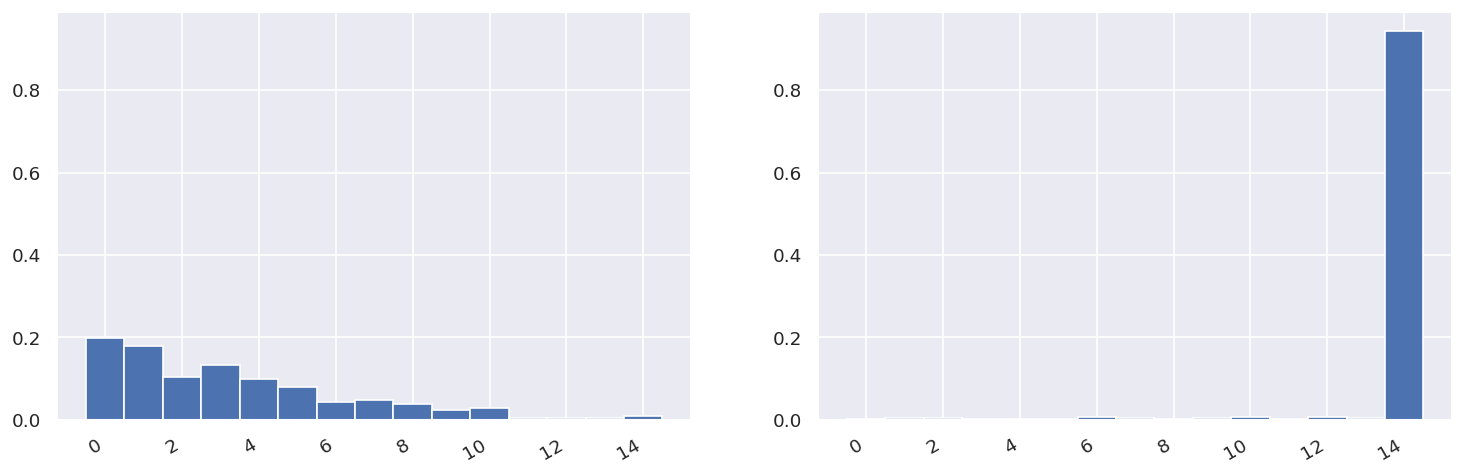

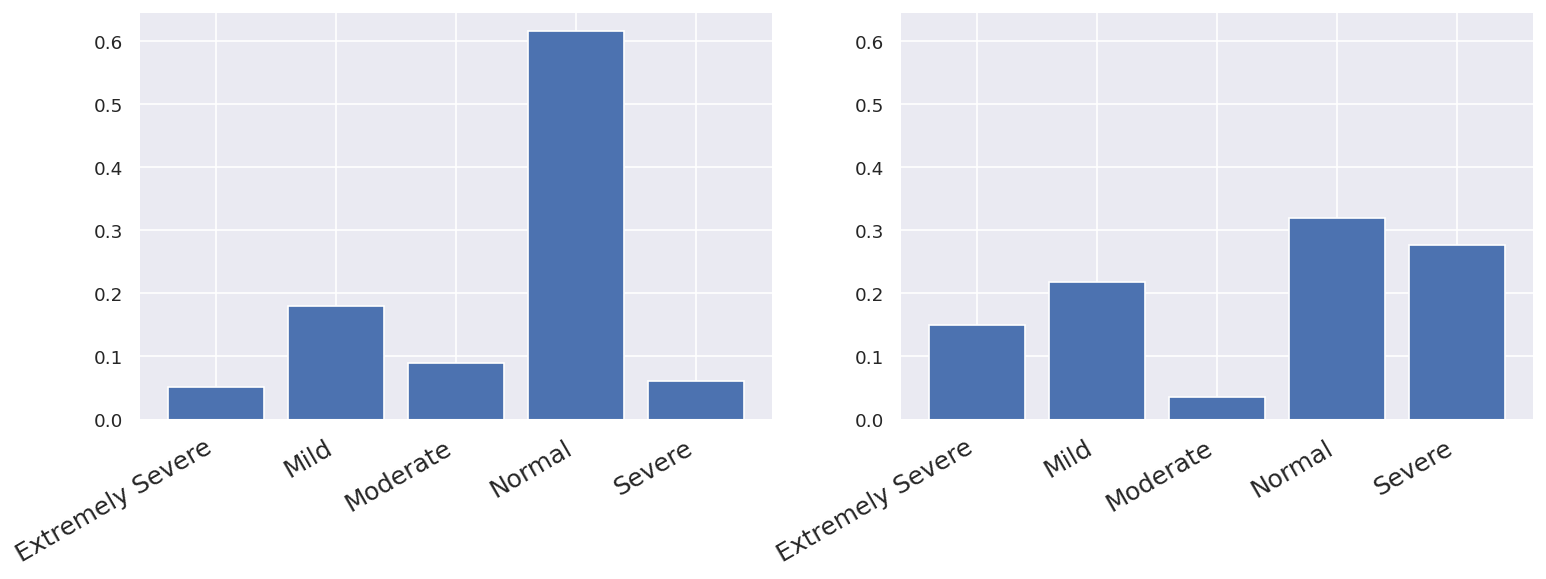

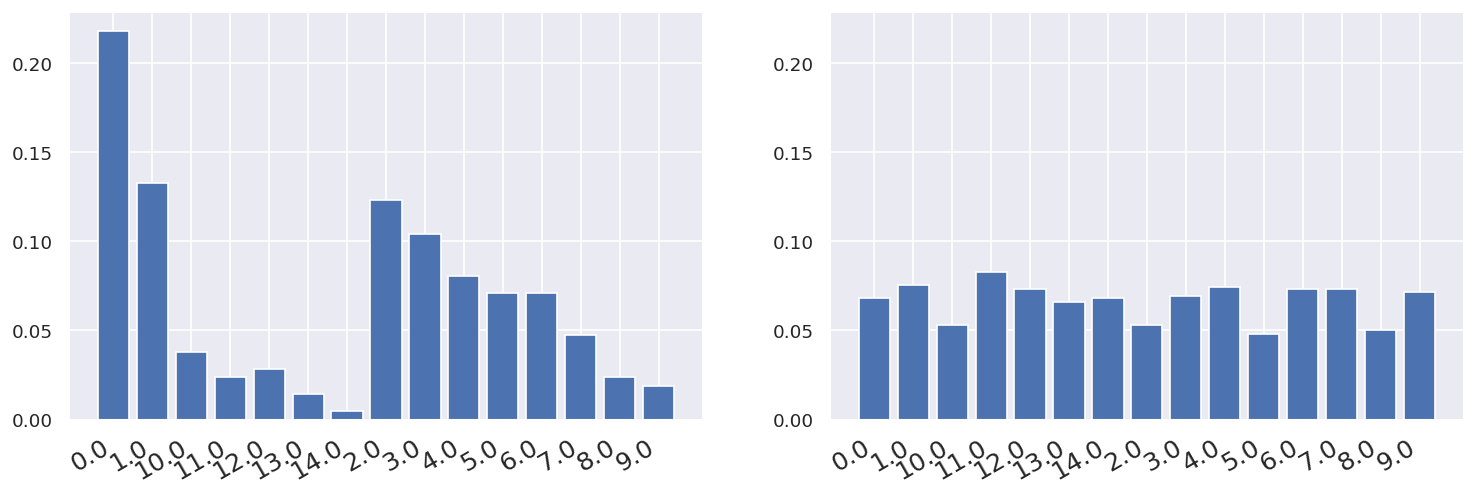

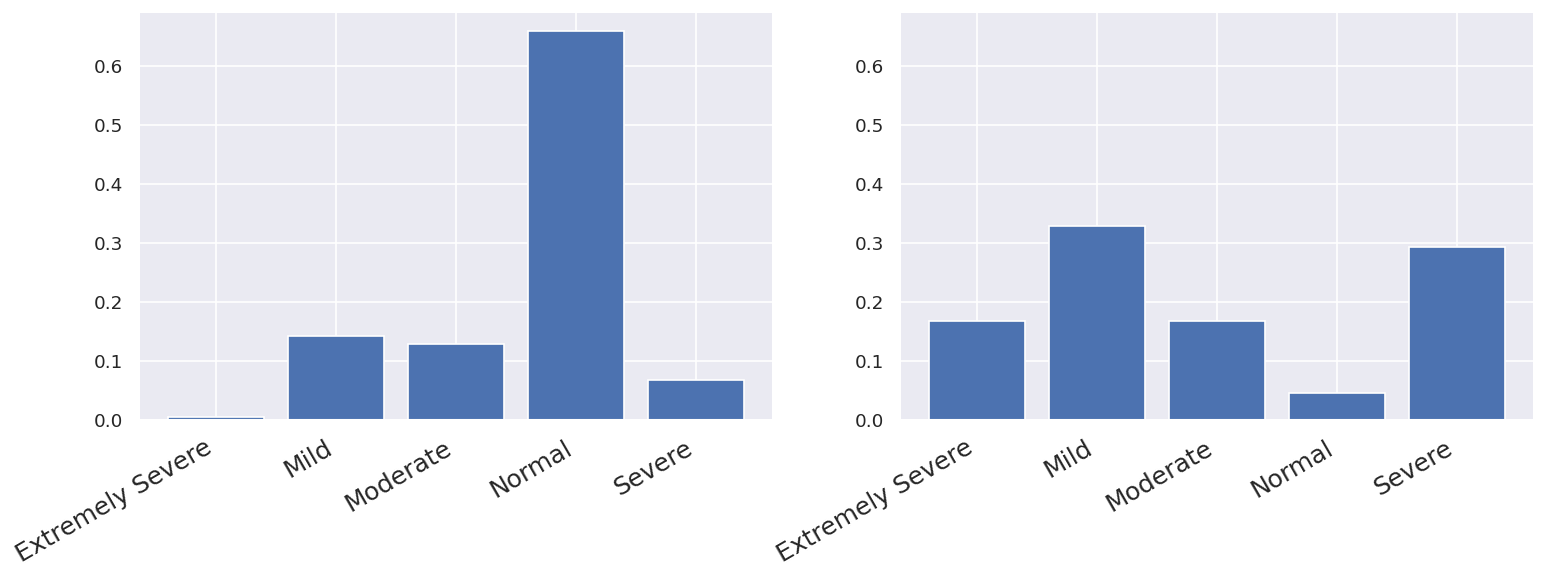

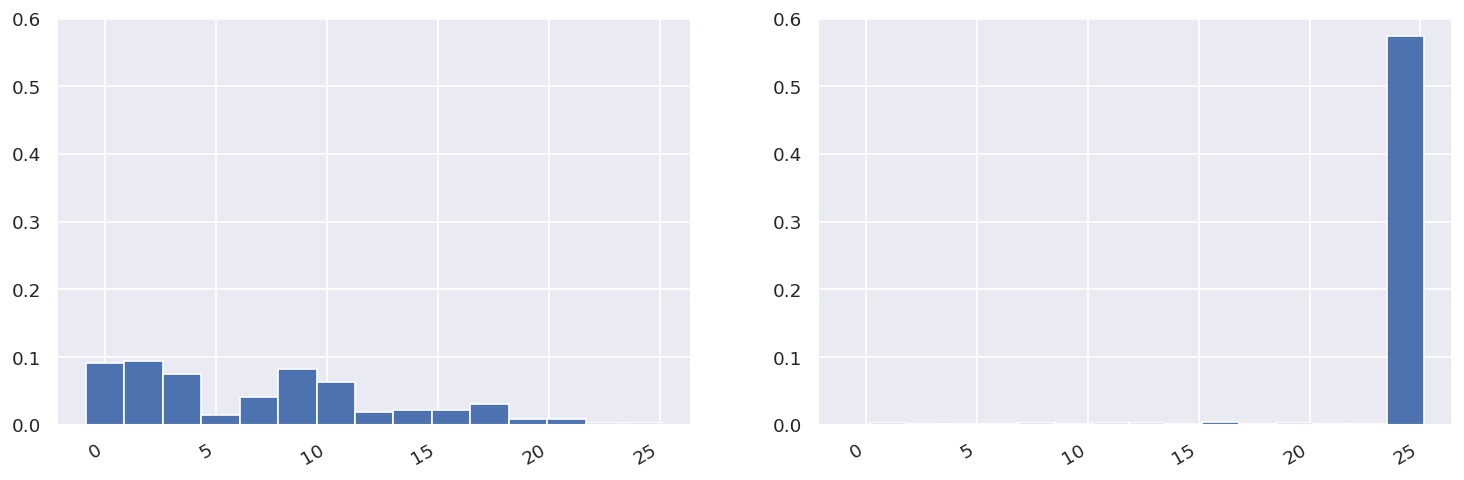

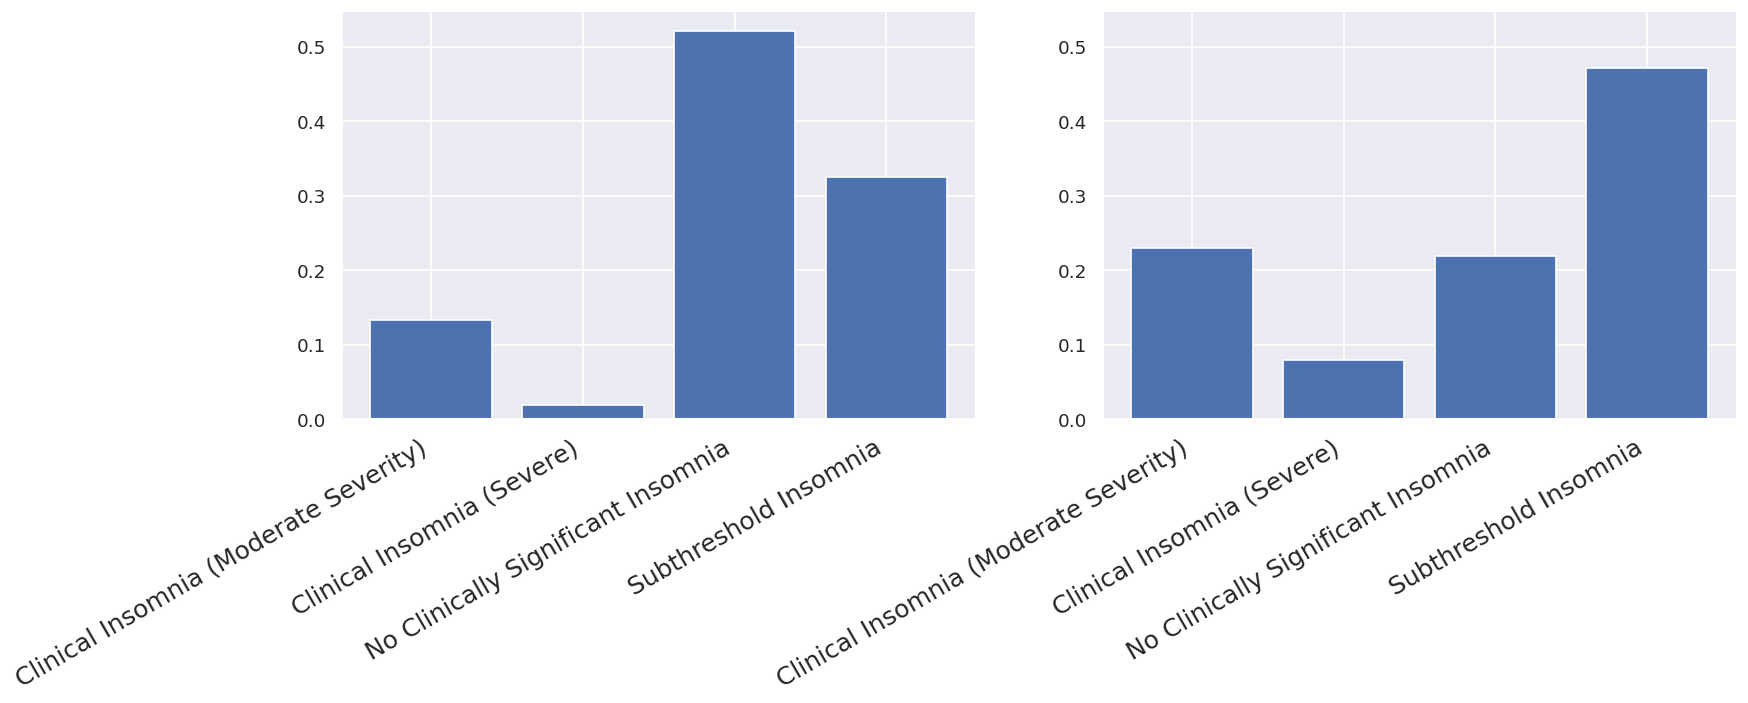

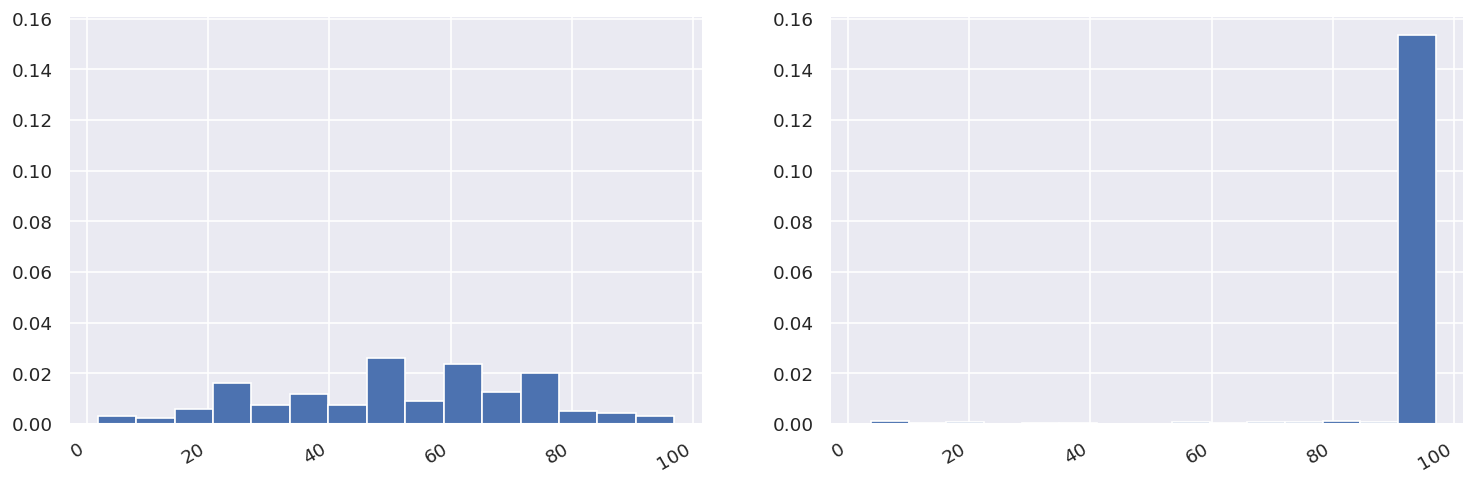

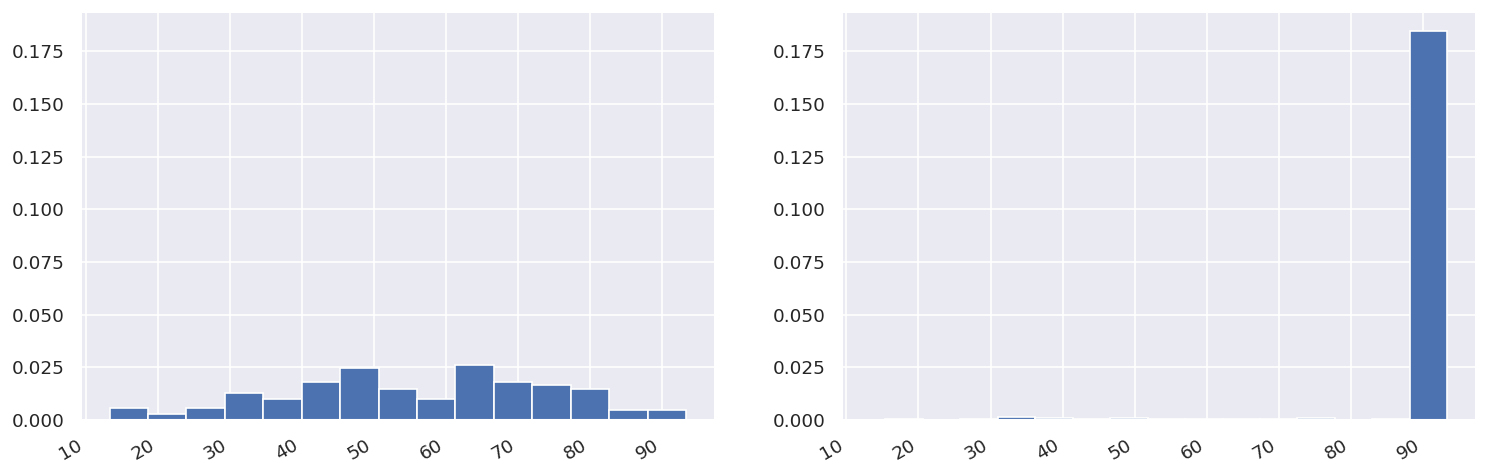

In [17]:
for attribute in synthetic_df.columns:
    print(attribute)
    inspector.compare_histograms(attribute)

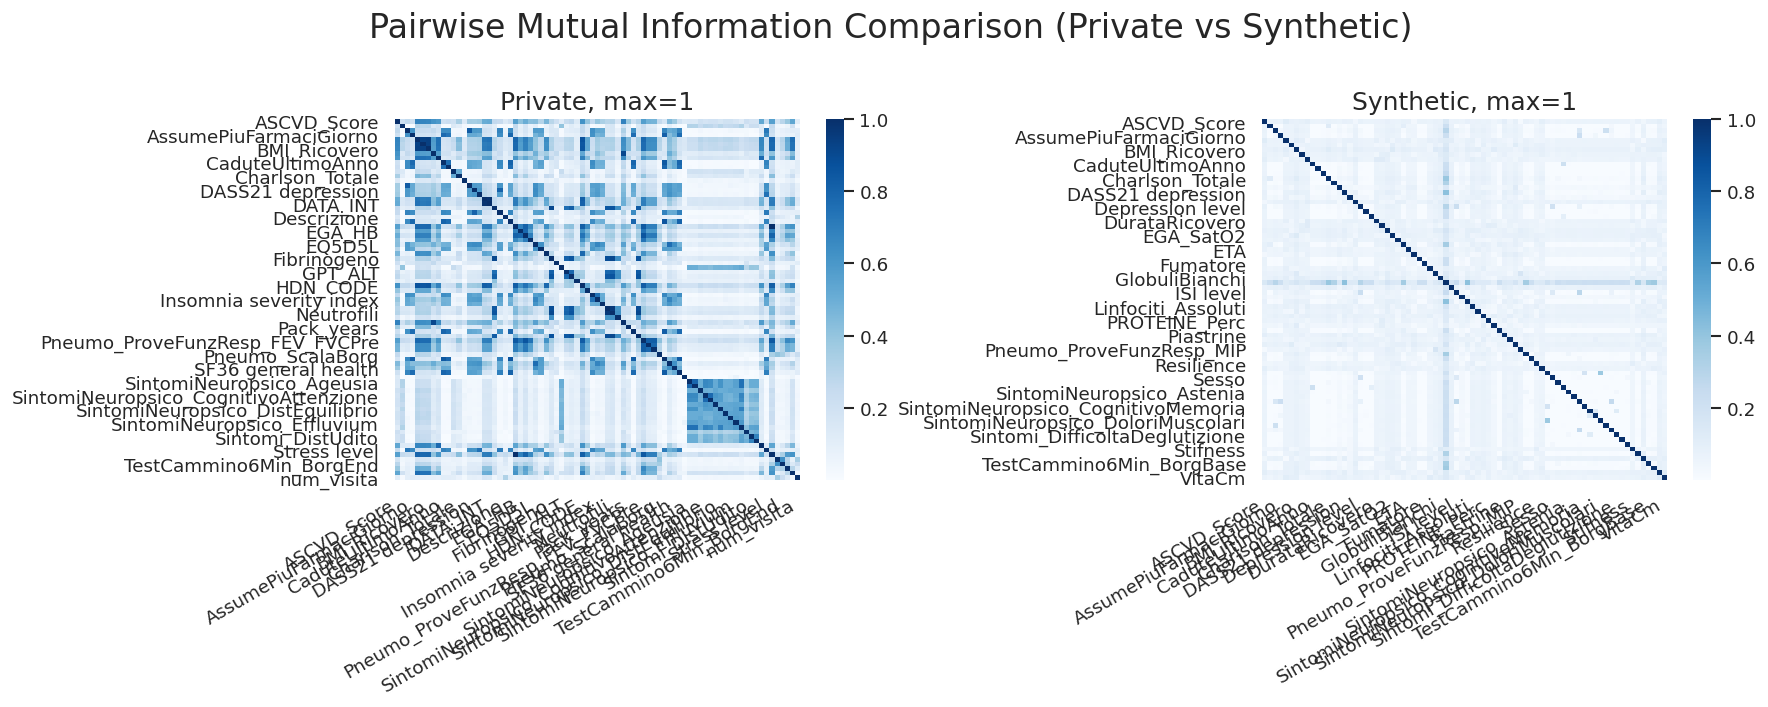

In [22]:
inspector.mutual_information_heatmap()

In [23]:
synthetic_df.head()

HDN_CODE Sesso   ETA  ASCVD_Score  Charlson_Totale  \
0  7962329.0     F  89.0        58.18              1.0   
1  9428914.0     F  89.0        58.18             10.0   
2  3966829.0     M  89.0        58.18              8.0   
3  9428914.0     M  89.0        58.18              3.0   
4  4821858.0     F  89.0          NaN              2.0   

                      Charlson_Diabete   Stifness    CAP  \
0  2 = Con danneggiamento degli organi  48.800000  400.0   
1                               0 = No  48.800000  400.0   
2  2 = Con danneggiamento degli organi  48.800000  400.0   
3                               0 = No  31.850885  400.0   
4                               0 = No  10.415109    NaN   

   FrailtyPhenotypeBool  EGA_HB  ...  DASS21 stress      Stress level  \
0                   0.0    20.9  ...           17.0  Extremely Severe   
1                   0.0    20.9  ...           17.0          Moderate   
2                   0.0    20.9  ...           17.0              Mild   
3                   NaN    20.9  ...           17.0            Severe   
4                   NaN    20.9  ...           17.0  Extremely Severe   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0            15.0            NaN                7.0  Extremely Severe   
1            15.0            NaN                3.0            Normal   
2            15.0            NaN               12.0            Severe   
3            15.0         Severe               11.0            Severe   
4            15.0           Mild                0.0              Mild   

  Insomnia severity index                           ISI level  \
0                    26.0                                 NaN   
1                    26.0  No Clinically Significant Insomnia   
2                    26.0                                 NaN   
3                    26.0               Subthreshold Insomnia   
4                    26.0               Subthreshold Insomnia   

   SF36 general health  Resilience  
0                100.0        96.0  
1                100.0        96.0  
2                100.0        96.0  
3                100.0        96.0  
4                100.0         NaN  

[5 rows x 76 columns]

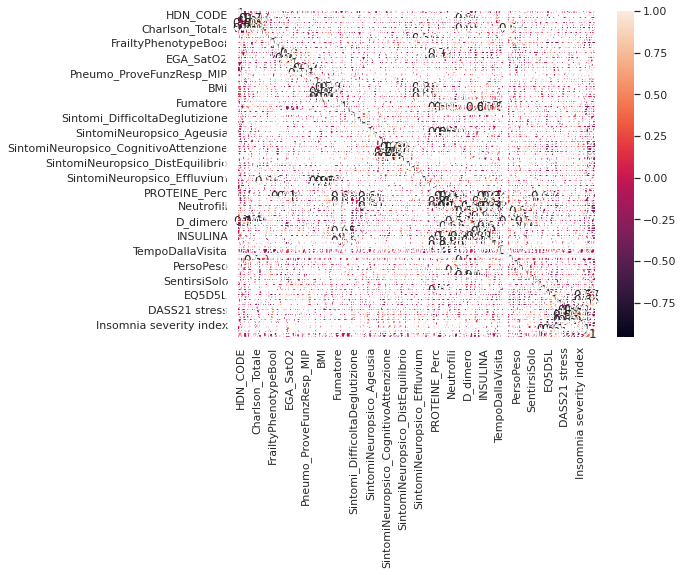

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(dfSenzaData.corr(), annot=True)
plt.show()